# FOR ALES: Analyzing the quality of NEIMS predictions (nedokonceno)

We want to know wether the NEIMS intensity prediction is any good. 

Ales se potrebuje podivat, jestli je NEIMS schopen nejak rozumne generovat spektra pro derivatizovany spektra

In [2]:
pip install spectrum-utils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from matchms.importing import load_from_msp
from matchms.filtering import normalize_intensities

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from rdkit.Chem import PandasTools
from pandas import DataFrame as df
from rdkit import Chem
from rdkit.Chem.inchi import MolToInchiKey

import os
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
from collections import Counter
import random

### Loading the data

#### NEIMS test Smiles to enriched SDF

In [16]:
def filter_corrupted_smiles(pp):
    print("before filtering corrupted molecules:", len(pp))
    for index, row in pp.iterrows():
        try:
#             print(row["ROMol"])
            mol = Chem.Mol(row["ROMol"])
        except:
            pp.drop(index, inplace=True)
    print("after filtering corrupted molecules:", len(pp))
    return pp

def prepare_smiles_for_enriching(smiles_file, output_prefix):        
    tmp_smiles_path = f"../NEIMS/tmp/{output_prefix}_tmp_smiles.txt"
    sdf_before = f"/storage/projects/msml/mg_neims_branch/NEIMS/tmp/{output_prefix}_tmp_before.sdf"
    sdf_after = f"/storage/projects/msml/mg_neims_branch/NEIMS/tmp/{output_prefix}_tmp_after.sdf"

    model_weights = "../NEIMS/NEIMS_weights"

    pp = pd.read_csv(smiles_file, names=['smiles']) 
    pp = pp.drop_duplicates(subset=['smiles'])
    pp["id"] = range(len(pp))
    pp = pp[["id", "smiles"]]
    PandasTools.AddMoleculeColumnToFrame(pp, smilesCol='smiles', molCol='ROMol')
    pp = pp.assign(inchikey=lambda x: [MolToInchiKey(mol) for mol in x["ROMol"]])#.set_index("ID")
    pp = filter_corrupted_smiles(pp)

    # filter pp to unique according to inchikey
    pp = pp.drop_duplicates(subset=["inchikey"])

    PandasTools.WriteSDF(pp, sdf_before, idName="id", properties=list(pp.columns))

    print(f"now run in terminal:\n###############\n. add_conda_NEIMSpy2.sh && bash /storage/projects/msml/mg_neims_branch/NEIMS/run_make_spectra_prediction.sh {sdf_before} {sdf_after} && conda deactivate\n###############\n")

# run it on the three datasets
data_path = "../MassGenie/data/trial_set/ales_smilesy/NIST_MeOX.txt"
prepare_smiles_for_enriching(data_path, "MeOX")

data_path = "../MassGenie/data/trial_set/ales_smilesy/NIST_ONSSiMe3.txt"
prepare_smiles_for_enriching(data_path, "ONSSiMe3")

data_path = "../MassGenie/data/trial_set/ales_smilesy/NIST_SiMe3.txt"
prepare_smiles_for_enriching(data_path, "SiMe3")

before filtering corrupted molecules: 254
after filtering corrupted molecules: 254
now run in terminal:
###############
. add_conda_NEIMSpy2.sh && bash /storage/projects/msml/mg_neims_branch/NEIMS/run_make_spectra_prediction.sh /storage/projects/msml/mg_neims_branch/NEIMS/tmp/MeOX_tmp_before.sdf /storage/projects/msml/mg_neims_branch/NEIMS/tmp/MeOX_tmp_after.sdf && conda deactivate
###############

before filtering corrupted molecules: 5916
after filtering corrupted molecules: 5916
now run in terminal:
###############
. add_conda_NEIMSpy2.sh && bash /storage/projects/msml/mg_neims_branch/NEIMS/run_make_spectra_prediction.sh /storage/projects/msml/mg_neims_branch/NEIMS/tmp/ONSSiMe3_tmp_before.sdf /storage/projects/msml/mg_neims_branch/NEIMS/tmp/ONSSiMe3_tmp_after.sdf && conda deactivate
###############

before filtering corrupted molecules: 7095
after filtering corrupted molecules: 7095
now run in terminal:
###############
. add_conda_NEIMSpy2.sh && bash /storage/projects/msml/mg_neims_

In [60]:
# pp.iloc[7000]

In [2]:
# neims_test_path = "../NEIMS/testdata/test_14_mend_all_valid.sdf"
neims_meox_path = "../NEIMS/tmp/MeOX_tmp_after.sdf"
neims_ONSSiMe3_path = "../NEIMS/tmp/ONSSiMe3_tmp_after.sdf"
neims_SiMe3_path = "../NEIMS/tmp/SiMe3_tmp_after.sdf"
nist_path = "./data/20210925_NIST_EI_MS_cleaned.msp"



In [3]:
%%time
nist = [*load_from_msp(nist_path)]

CPU times: user 1min 4s, sys: 1.54 s, total: 1min 6s
Wall time: 1min 5s


In [4]:
nist[33]

In [5]:
neims_meox = PandasTools.LoadSDF(neims_meox_path, idName="ID", smilesName='Smiles', molColName='Molecule')
neims_ONSSiMe3 = PandasTools.LoadSDF(neims_ONSSiMe3_path, idName="ID", smilesName='Smiles', molColName='Molecule')
neims_SiMe3 = PandasTools.LoadSDF(neims_SiMe3_path, idName="ID", smilesName='Smiles', molColName='Molecule')

In [6]:
neims_meox["inchikey"]

0      TZXJBRONCJNUGM-UHFFFAOYSA-N
1      RDATZQIINHXKAG-UHFFFAOYSA-N
2      MZVDWEVOVDFJCG-UHFFFAOYSA-N
3      WBUUEQUAMHQROV-UHFFFAOYSA-N
4      CALQXVJPGUTRRJ-UHFFFAOYSA-N
                  ...             
249    KNAZTEWBFRPMHZ-UHFFFAOYSA-N
250    GHLBZCVNTDKTAN-UHFFFAOYSA-N
251    IBUWRFQPAQWUEY-UHFFFAOYSA-N
252    VQPHJUFIZVDKSU-UHFFFAOYSA-N
253    MRJCSXFCSPYKSK-UHFFFAOYSA-N
Name: inchikey, Length: 254, dtype: object

# Create all containing dataset

In [7]:
key = "inchikey"
neims_ids = neims_meox[key].tolist()
neims_ids += neims_ONSSiMe3[key].tolist()
neims_ids += neims_SiMe3[key].tolist()
neims_ids = list(np.unique(np.array(neims_ids)))

In [61]:
len(neims_ids)

7115

In [9]:
df = pd.DataFrame(neims_ids, columns=["inchikey"])

In [67]:
%%time
df["MEOX"] = [neims_meox["inchikey"].str.contains(x).any() for x in df["inchikey"]]
df["ONSSiMe3"] = [neims_ONSSiMe3["inchikey"].str.contains(x).any() for x in df["inchikey"]]
df["SiMe3"] = [neims_SiMe3["inchikey"].str.contains(x).any() for x in df["inchikey"]]

In [72]:
# pocet celkovych hodnot True vs. pocet molekul
sum(df.ONSSiMe3) + sum(df.SiMe3) + sum(df.MEOX), len(df)

(13265, 7115)

In [ ]:
# pridat name	smiles	inchikey	superclass	simil	w_simil	matched_peaks_neims	matched_rate	nist_spec	neims_spec	molecule

NameError: name 'df' is not defined

In [9]:
%%time
# get NIST ids of molecules in the test set
def get_nist_spec_match(key):
    df = pd.DataFrame(columns=[])
    neims_ids = neims_meox[key].tolist()
    neims_ids += neims_ONSSiMe3[key].tolist()
    neims_ids += neims_SiMe3[key].tolist()
    neims_ids = list(np.array(neims_ids).unique())
#     print(neims_ids)
    ids = []
    no_inchi = []
    counter = 0
    for i, x in enumerate(nist):
        try:
#             print( nist[i].metadata[key])
            id_ = nist[i].metadata[key]
            if id_ in neims_ids:            
                nist[i].metadata["smiles"] # test for smiles presence
                
                counter += 1
                ids.append((i, id_))
                neims_ids.remove(id_)
                
        except:
            no_inchi.append(i)
    print("matched ids: ", counter, "/", counter+len(neims_ids))
    return sorted(ids), no_inchi
        
key = "inchikey"
ids, no_inchi = get_nist_spec_match(key) 

len(neims_test)
~neims_test.inchikey.isin([y for x,y in ids])
neims_test.drop(neims_test[~neims_test.inchikey.isin([y for x,y in ids])].index, inplace=True)
len(neims_test)
neims_test = neims_test.assign(nist_idMINUS1=lambda x : [i for inch in x[key] for i,k in ids if inch==k])

matched ids:  10824 / 11600
CPU times: user 36.9 s, sys: 294 ms, total: 37.2 s
Wall time: 37.2 s


smiles                     inchikey  \
0                                     Br  CPELXLSAUQHCOX-UHFFFAOYSA-N   
1          Br/C(=C(/Br)c1ccccc1)c1ccccc1  XNJYRGMCZCPTJE-BUHFOSPRSA-N   
2            Br/C=C/C12CC3CC(CC(C3)C1)C2  IAXZFIQPFQKZQN-OWOJBTEDSA-N   
3                        Br/C=C\c1ccccc1  YMOONIIMQBGTDU-SREVYHEPSA-N   
4      BrC(=C(c1ccccc1)c1ccccc1)c1ccccc1  VUQVJIUBUPPCDB-UHFFFAOYSA-N   
...                                  ...                          ...   
11595        c1csc(C2(N3CCCCC3)CCCCC2)c1  JUZZEWSCNBCFRL-UHFFFAOYSA-N   
11596                            c1cscn1  FZWLAAWBMGSTSO-UHFFFAOYSA-N   
11597                         c1nc[nH]n1  NSPMIYGKQJPBQR-UHFFFAOYSA-N   
11598                           c1ncncn1  JIHQDMXYYFUGFV-UHFFFAOYSA-N   
11599                         c1nnn[nH]1  KJUGUADJHNHALS-UHFFFAOYSA-N   

                                      PREDICTED SPECTRUM     ID  \
0      15 84\n16 83\n17 130\n19 49\n25 132\n26 255\n2...  10576   
1      15 16\n26 39\n27 50\n28 44\n37 56\n38 127\n39 ...   3646   
2      27 0\n29 31\n36 10\n38 41\n39 260\n40 127\n41 ...   3031   
3      14 11\n15 9\n25 41\n26 114\n27 143\n28 71\n29 ...   9848   
4      26 4\n27 66\n28 12\n38 8\n39 104\n50 146\n51 2...   2582   
...                                                  ...    ...   
11595  33 3\n34 13\n39 95\n40 10\n41 264\n42 134\n43 ...  11284   
11596  14 24\n25 41\n26 114\n27 141\n28 83\n31 21\n32...   5191   
11597  14 27\n16 3\n25 39\n26 94\n27 43\n28 200\n29 3...   5390   
11598  14 78\n25 96\n26 497\n27 934\n28 639\n29 299\n...    860   
11599  14 94\n15 8\n16 49\n17 8\n25 69\n26 140\n27 19...   7270   

                                  Smiles  \
0                                     Br   
1          Br/C(=C(/Br)c1ccccc1)c1ccccc1   
2            Br/C=C/C12CC3CC(CC(C3)C1)C2   
3                        Br/C=C\c1ccccc1   
4      BrC(=C(c1ccccc1)c1ccccc1)c1ccccc1   
...                                  ...   
11595        c1csc(C2(N3CCCCC3)CCCCC2)c1   
11596                            c1cscn1   
11597                         c1nc[nH]n1   
11598                           c1ncncn1   
11599                         c1nnn[nH]1   

                                                Molecule  nist_idMINUS1  
0      <img data-content="rdkit/molecule" src="data:i...           1188  
1      <img data-content="rdkit/molecule" src="data:i...         243234  
2      <img data-content="rdkit/molecule" src="data:i...         122955  
3      <img data-content="rdkit/molecule" src="data:i...          57431  
4      <img data-content="rdkit/molecule" src="data:i...         241590  
...                                                  ...            ...  
11595  <img data-content="rdkit/molecule" src="data:i...         134526  
11596  <img data-content="rdkit/molecule" src="data:i...           1723  
11597  <img data-content="rdkit/molecule" src="data:i...            539  
11598  <img data-content="rdkit/molecule" src="data:i...           1265  
11599  <img data-content="rdkit/molecule" src="data:i...            667  

[10824 rows x 7 columns]
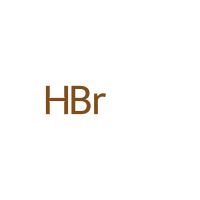
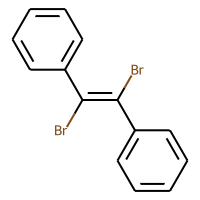
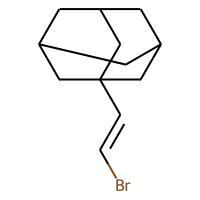
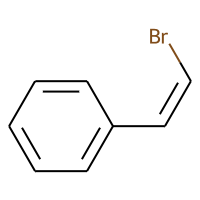
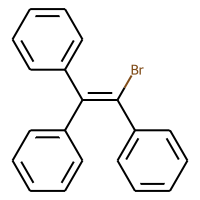
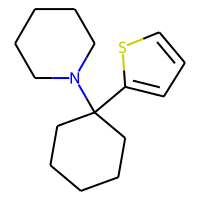
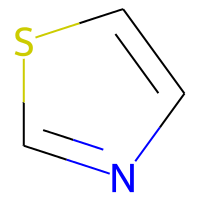
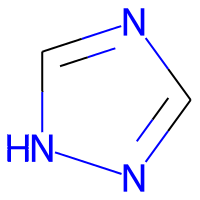
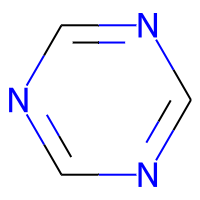
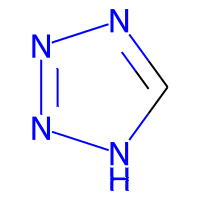

In [10]:
neims_test



In [11]:
# !ls
# path="nist_test_smiles.txt"
# with open(path, "w+") as f:
#     for id_, t in enumerate(neims_test.smiles):
#         f.write(str(ids[id_][1]) + "\t" + t + "\n")
ids

[(14, 'VGGSQFUCUMXWEO-UHFFFAOYSA-N'),
 (21, 'OTMSDBZUPAUEDD-UHFFFAOYSA-N'),
 (29, 'BAVYZALUXZFZLV-UHFFFAOYSA-N'),
 (35, 'OAKJQQAXSVQMHS-UHFFFAOYSA-N'),
 (40, 'AVXURJPOCDRRFD-UHFFFAOYSA-N'),
 (48, 'VEXZGXHMUGYJMC-UHFFFAOYSA-N'),
 (60, 'QQONPFPTGQHPMA-UHFFFAOYSA-N'),
 (73, 'OWIKHYCFFJSOEH-UHFFFAOYSA-N'),
 (87, 'ATUOYWHBWRKTHZ-UHFFFAOYSA-N'),
 (90, 'CURLTUGMZLYLDI-UHFFFAOYSA-N'),
 (95, 'QUSNBJAOOMFDIB-UHFFFAOYSA-N'),
 (97, 'ROSDSFDQCJNGOL-UHFFFAOYSA-N'),
 (120, 'GMPKIPWJBDOURN-UHFFFAOYSA-N'),
 (127, 'SAWKFRBJGLMMES-UHFFFAOYSA-N'),
 (135, 'JMANVNJQNLATNU-UHFFFAOYSA-N'),
 (137, 'WFYPICNXBKQZGB-UHFFFAOYSA-N'),
 (143, 'NLHHRLWOUZZQLW-UHFFFAOYSA-N'),
 (152, 'KDKYADYSIPSCCQ-UHFFFAOYSA-N'),
 (153, 'XNMQEEKYCVKGBD-UHFFFAOYSA-N'),
 (158, 'KAKZBPTYRLMSJV-UHFFFAOYSA-N'),
 (168, 'FVSKHRXBFJPNKK-UHFFFAOYSA-N'),
 (169, 'JKANAVGODYYCQF-UHFFFAOYSA-N'),
 (179, 'DFNYGALUNNFWKJ-UHFFFAOYSA-N'),
 (193, 'IAQRGUVFOMOMEM-ARJAWSKDSA-N'),
 (199, 'PMPVIKIVABFJJI-UHFFFAOYSA-N'),
 (201, 'IAQRGUVFOMOMEM-ONEGZZNKSA-N')

In [13]:
# filter out samples without smiles
def create_nist_data(nist, ids):
    nist_test_spec = {}
    didnt_work = []
    for id_, inchi in ids:
#         assert inchi == nist[id_].metadata["inchikey"]
#         print(id_)
        try:
            nist_test_spec[id_] = {"name": nist[id_].metadata["name"],  
                               "smiles": nist[id_].metadata["smiles"], 
                               "inchikey": nist[id_].metadata["inchikey"],
                               "mz": nist[id_].peaks.mz.astype(int),
                               "intensity": nist[id_].peaks.intensities/max(nist[id_].peaks.intensities)}
    #         print(nist[id_].metadata["smiles"])
        except:
            print(nist[id_].metadata)
            didnt_work.append(id_)
    return nist_test_spec, didnt_work

nist_test_spec, didnt_work = create_nist_data(nist, ids)

In [14]:
print(f"NIST specs that have smiles and everything: {len(nist_test_spec)}/{len(ids)}")

NIST specs that have smiles and everything: 10824/10824


In [15]:
nist_test_spec

{14: {'name': 'Ethylene',
  'smiles': 'C=C',
  'inchikey': 'VGGSQFUCUMXWEO-UHFFFAOYSA-N',
  'mz': array([ 2, 12, 13, 14, 15, 24, 25, 26, 27, 28, 29, 30]),
  'intensity': array([0.001001  , 0.00500501, 0.008999  , 0.021001  , 0.003003  ,
         0.023003  , 0.07800801, 0.52904905, 0.62306306, 1.        ,
         0.023003  , 0.001001  ])},
 21: {'name': 'Ethane',
  'smiles': 'CC',
  'inchikey': 'OTMSDBZUPAUEDD-UHFFFAOYSA-N',
  'mz': array([ 2, 12, 13, 14, 15, 16, 24, 25, 26, 27, 28, 29, 30, 31]),
  'intensity': array([0.002002  , 0.004004  , 0.01      , 0.03      , 0.044004  ,
         0.001001  , 0.00500501, 0.03500501, 0.23202202, 0.33203203,
         1.        , 0.21502503, 0.26202202, 0.00500501])},
 29: {'name': 'Methylamine',
  'smiles': 'CN',
  'inchikey': 'BAVYZALUXZFZLV-UHFFFAOYSA-N',
  'mz': array([13, 14, 15, 16, 17, 18, 26, 27, 28, 29, 30, 31, 32]),
  'intensity': array([0.002002  , 0.004004  , 0.04      , 0.004004  , 0.007998  ,
         0.011001  , 0.008999  , 0.08201201,



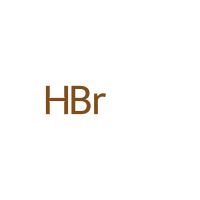

In [16]:
################### SMAZ
print(neims_test["Molecule"][0])


###################

In [17]:
# create neims dataset
def process_neims_spec(spec, smiles):
    spec = spec.split("\n")
    i = []
    mz = []
    for t in spec:
        j,d = t.split()
        mz.append(j)
        i.append(d)
    return {"smiles": smiles, "mz": np.array(mz).astype(int), "intensity": np.array(i).astype(float)/max(np.array(i).astype(float))}

neims_test_spec = {}
for i, ps in neims_test.sort_values(by=['nist_idMINUS1'])[["nist_idMINUS1", "PREDICTED SPECTRUM", "smiles"]].iterrows():
    neims_test_spec[int(ps["nist_idMINUS1"])] = process_neims_spec(ps["PREDICTED SPECTRUM"], ps["smiles"])
#     print(psneims_test_spec[ps["ID"]] = ["PREDICTED SPECTRUM"])
#     print("--")
# neims_test_spec

In [18]:
print(neims_test_spec.keys() == nist_test_spec.keys())
print(len(nist_test_spec.keys()))
print(len(neims_test_spec.keys()))

True
10824
10824


## Spectra visualization

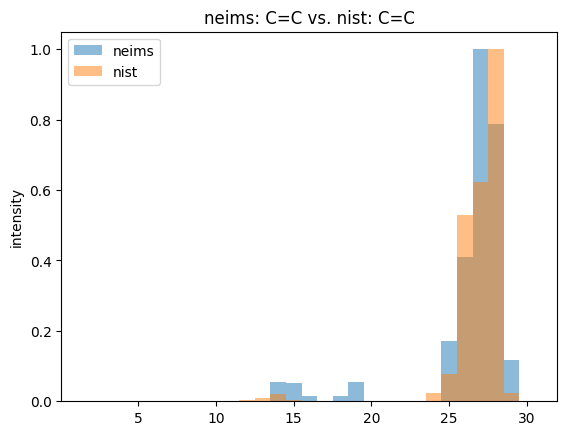

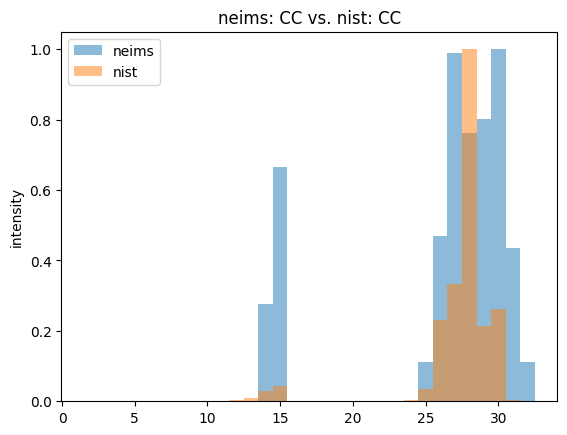

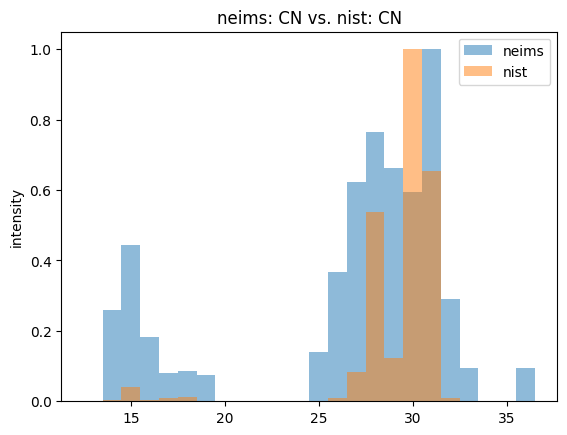

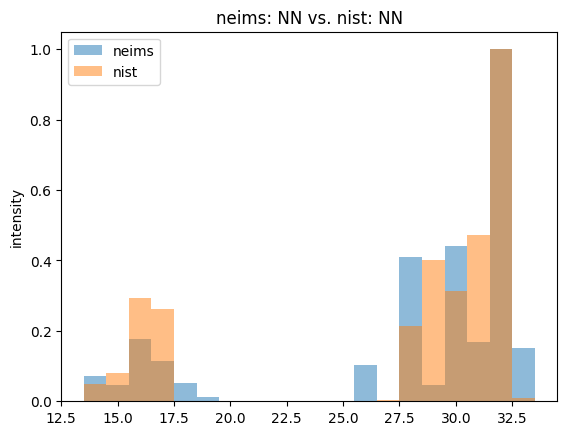

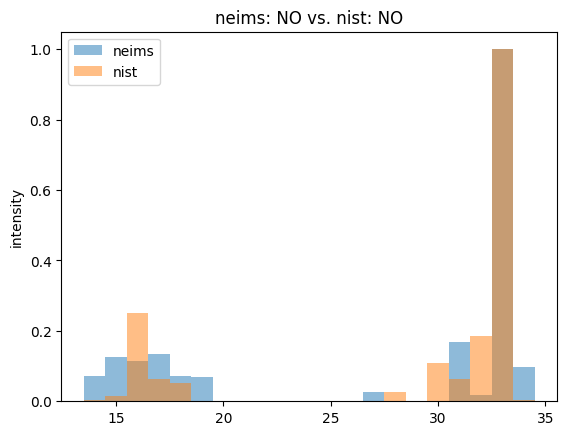

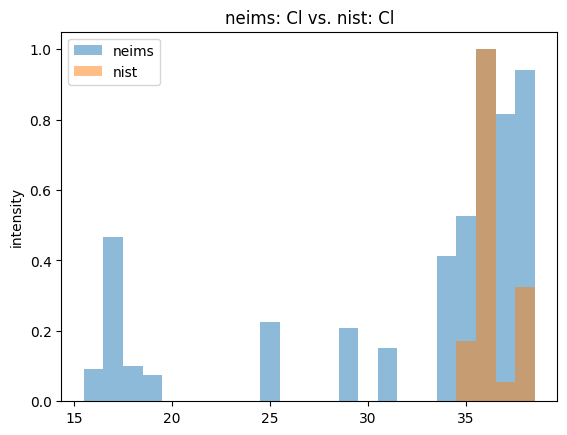

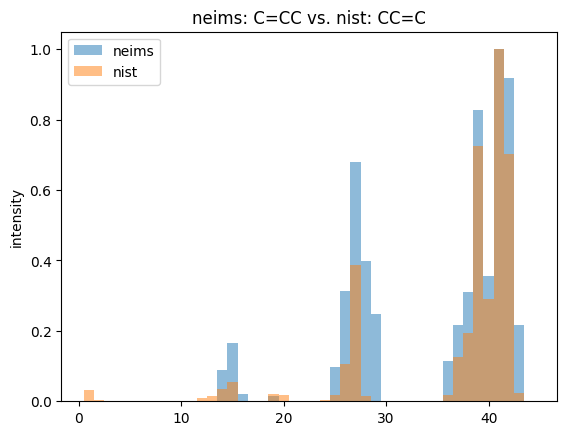

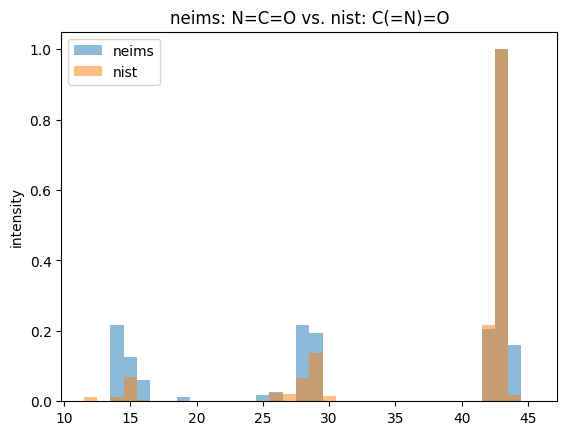

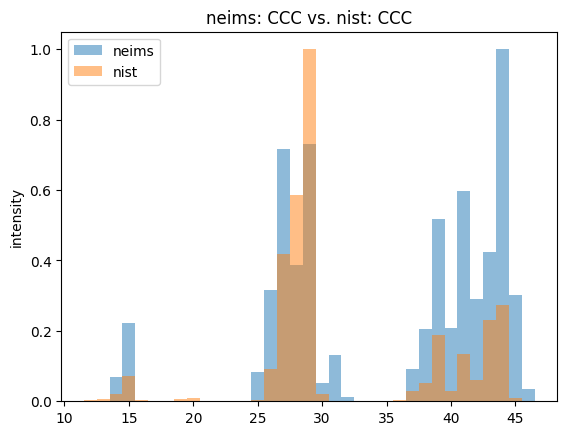

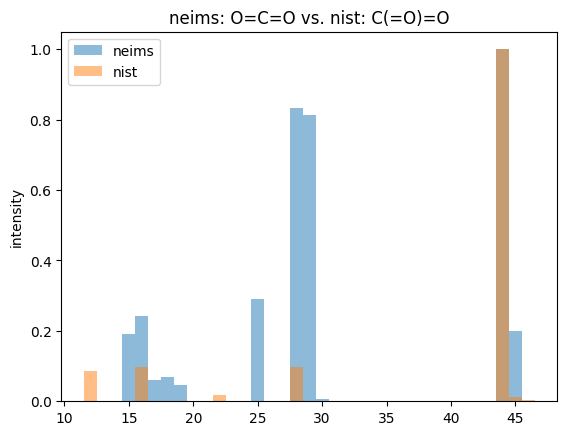

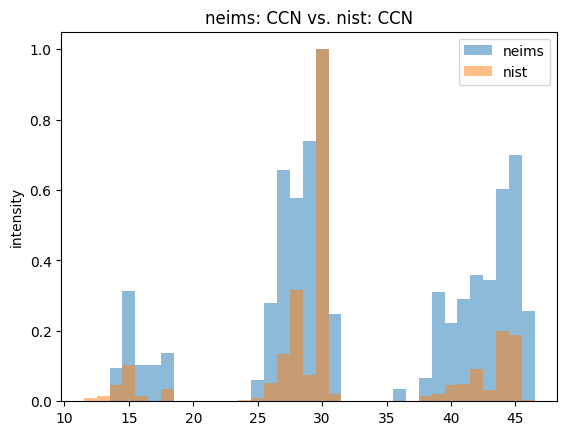

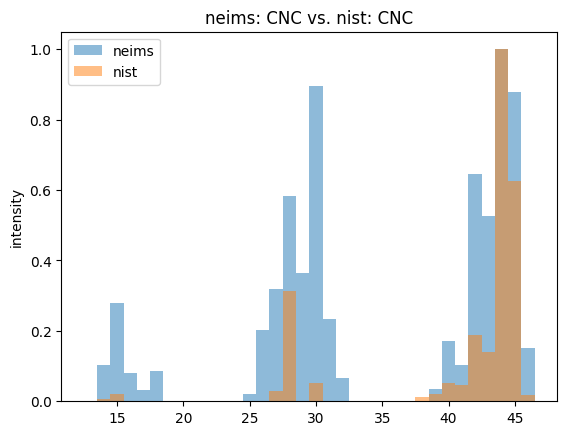

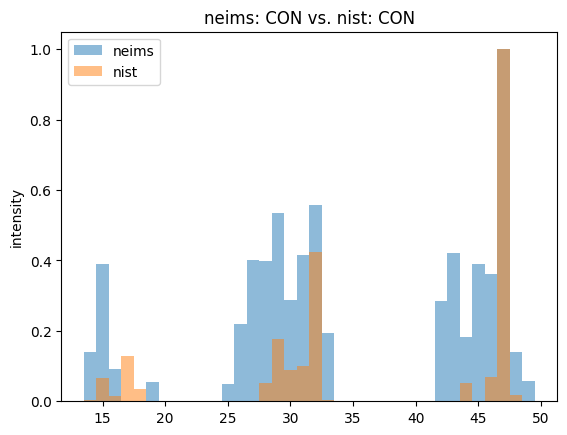

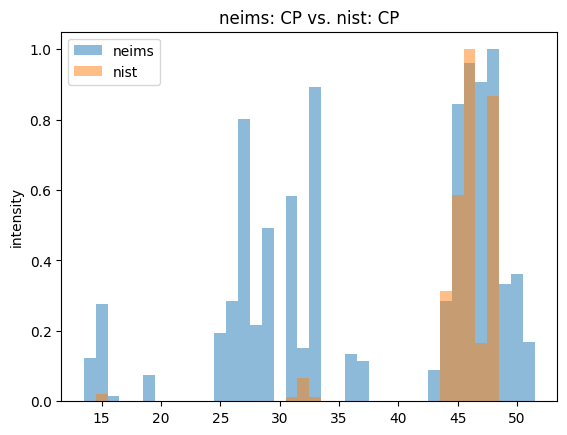

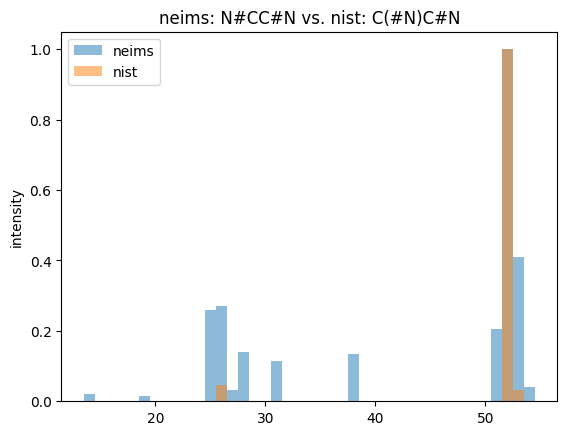

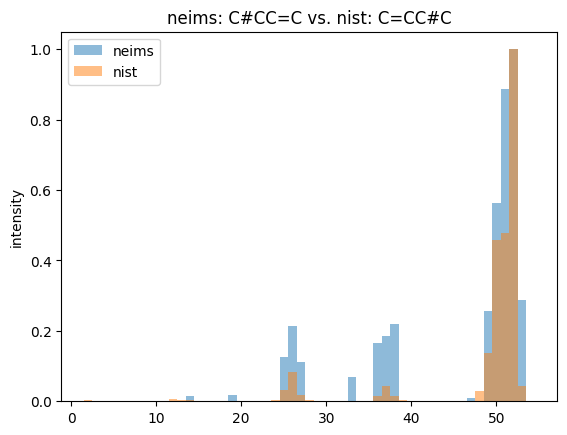

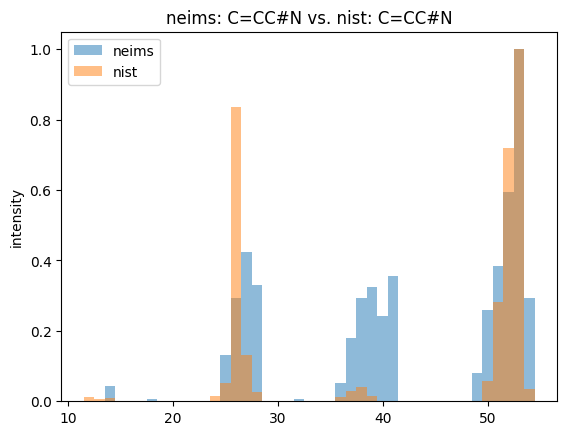

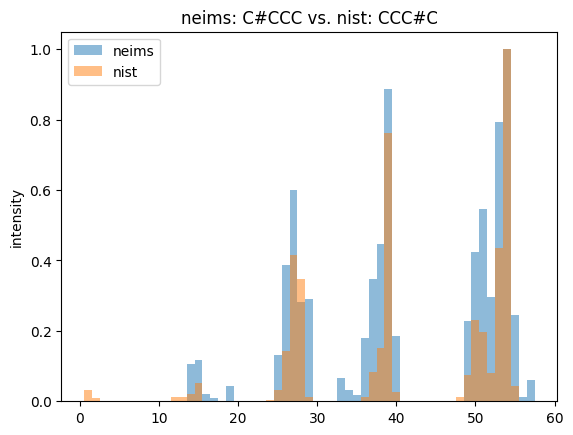

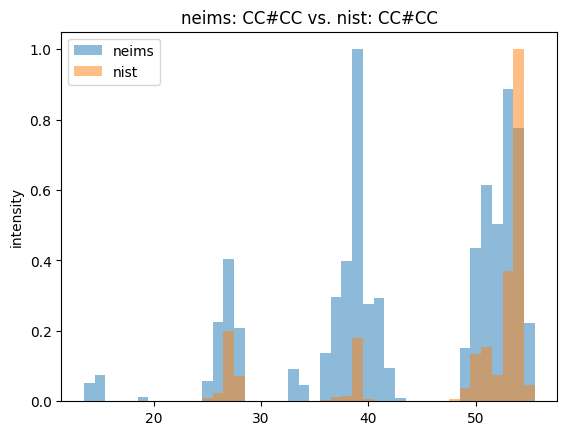

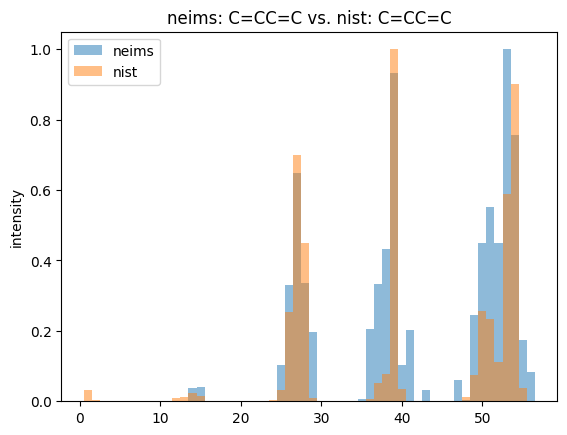

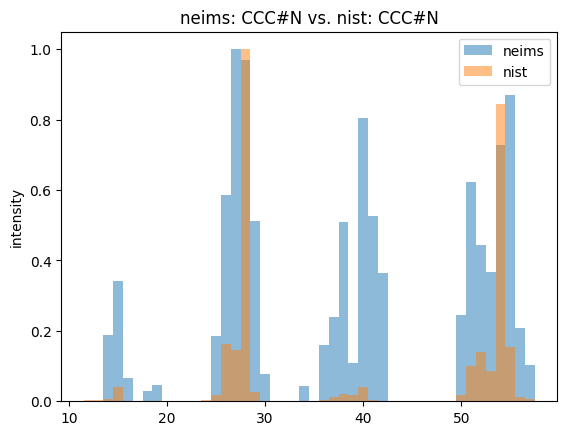

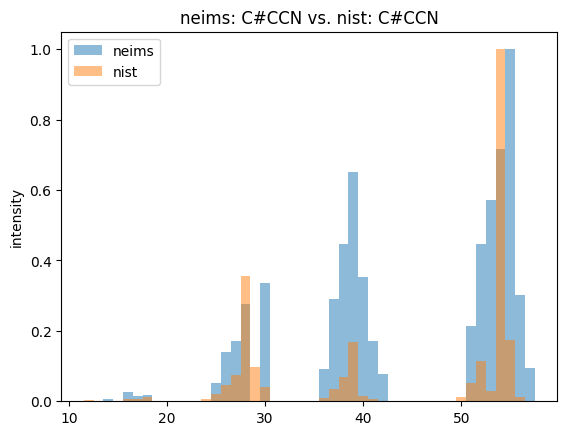

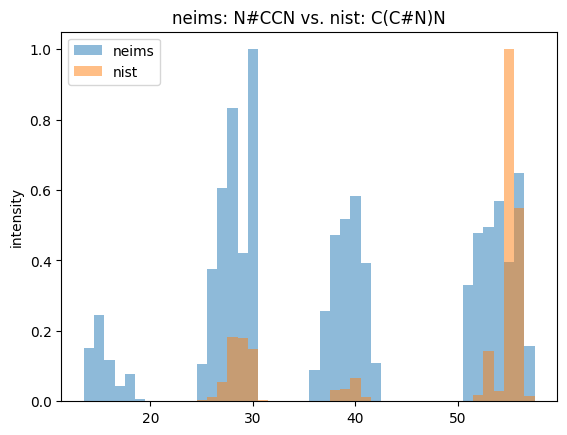

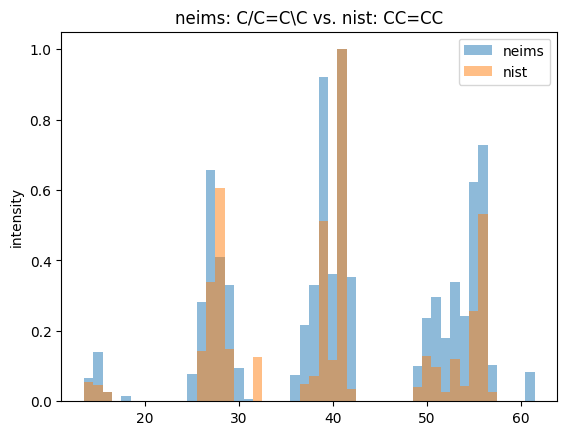

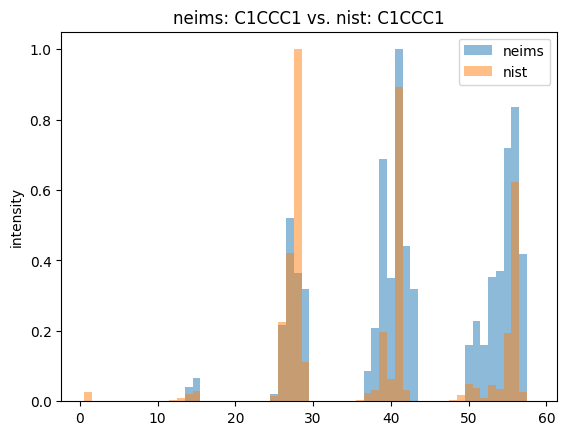

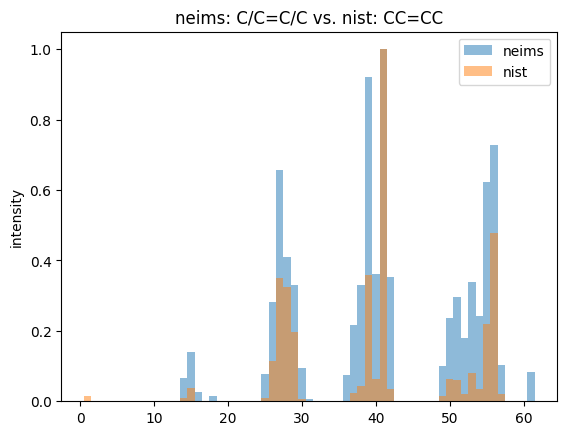

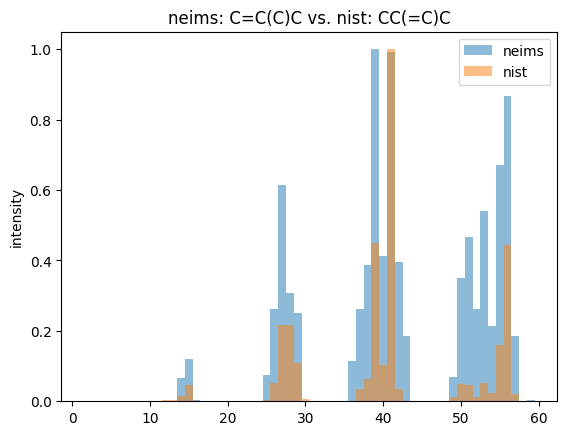

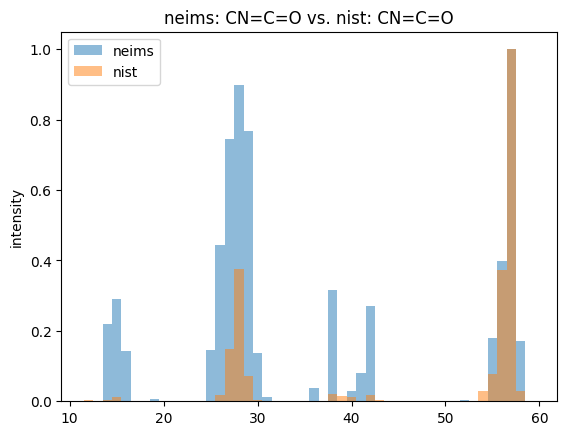

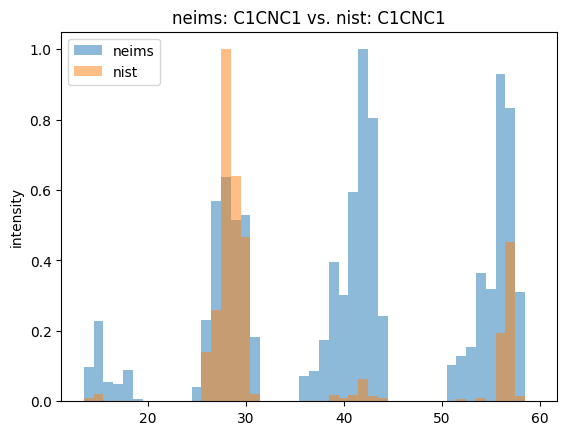

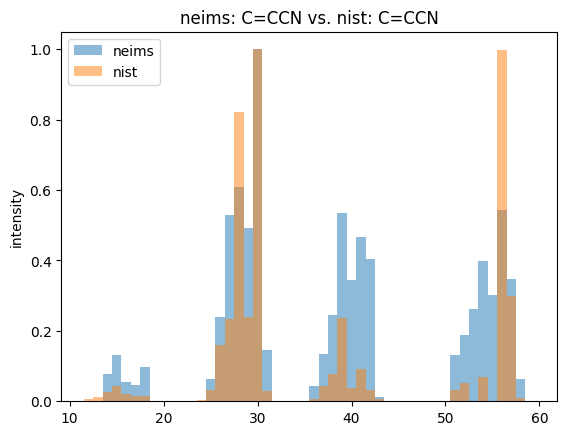

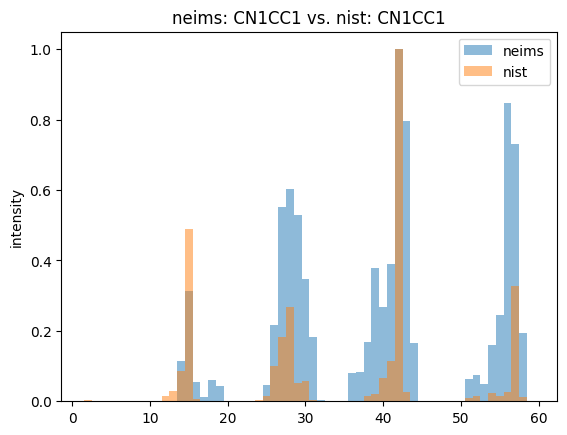

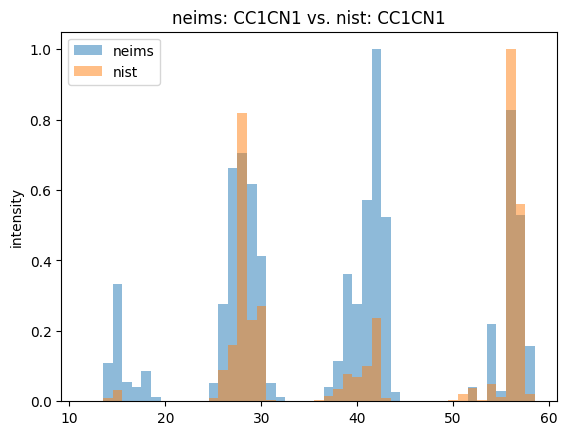

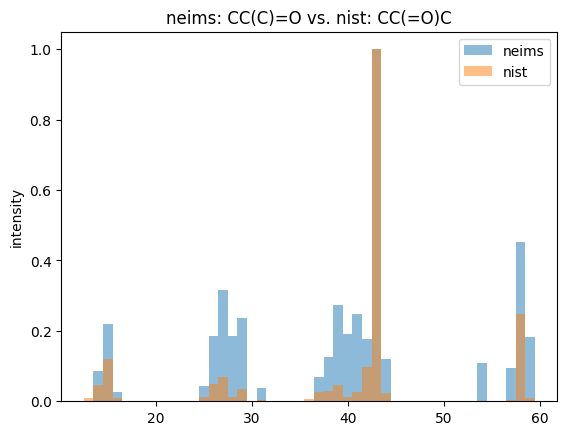

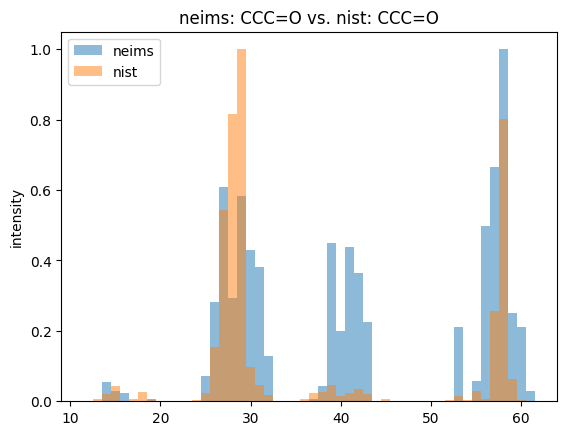

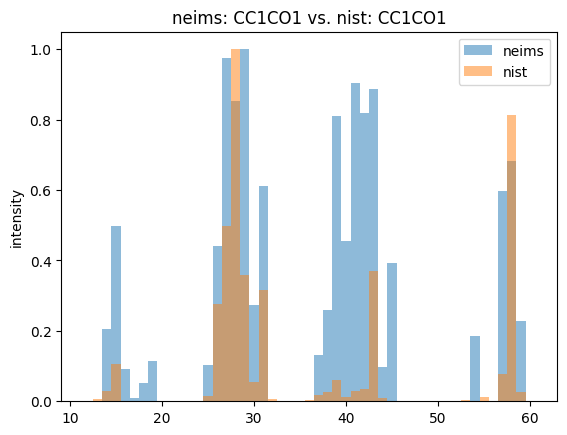

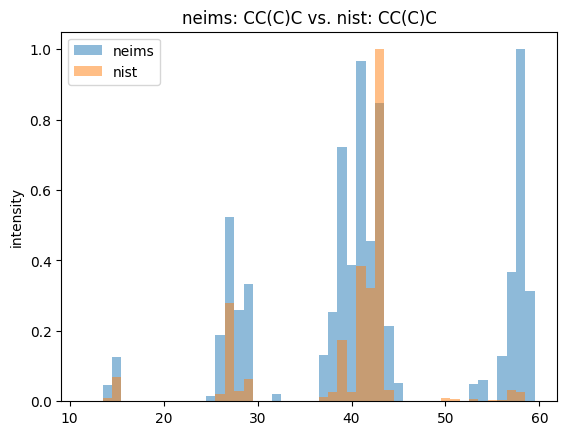

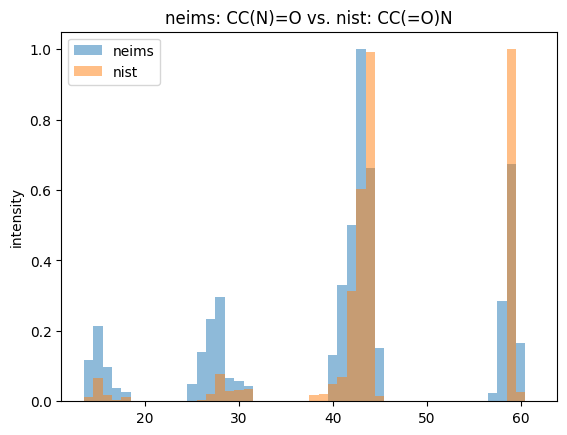

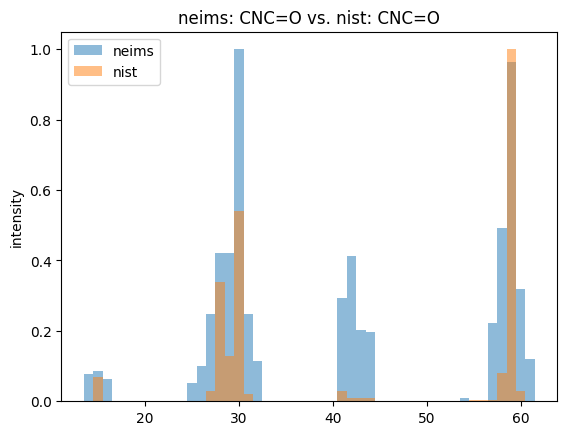

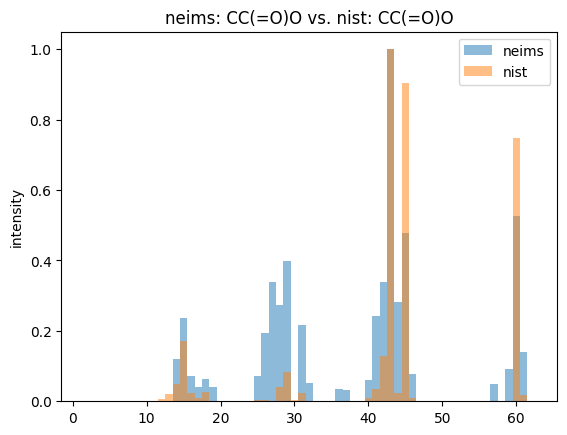

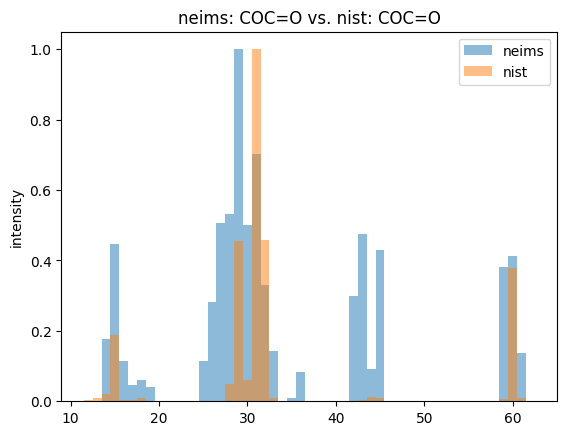

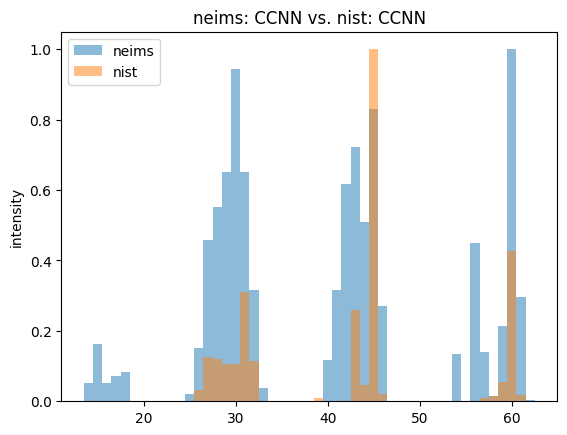

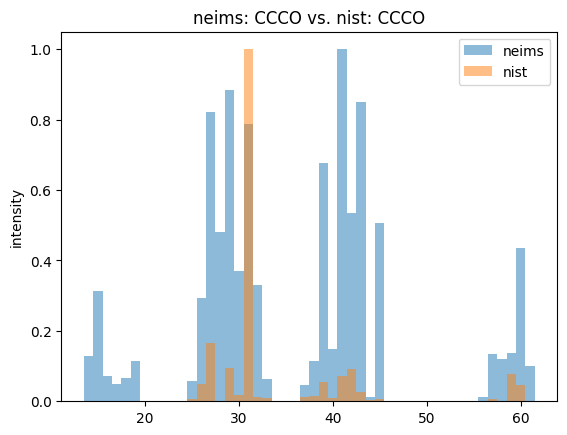

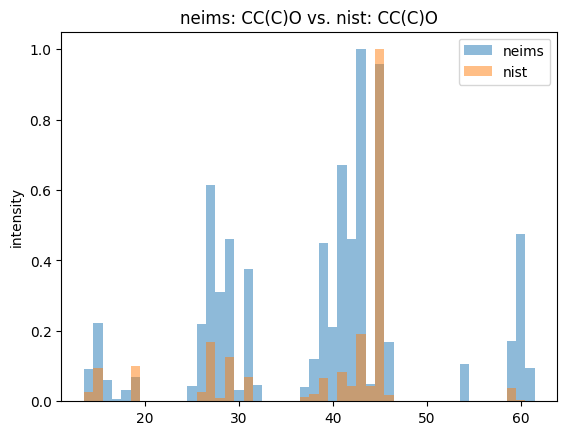

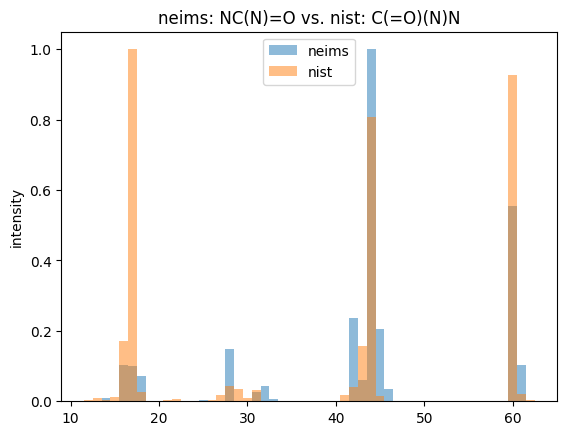

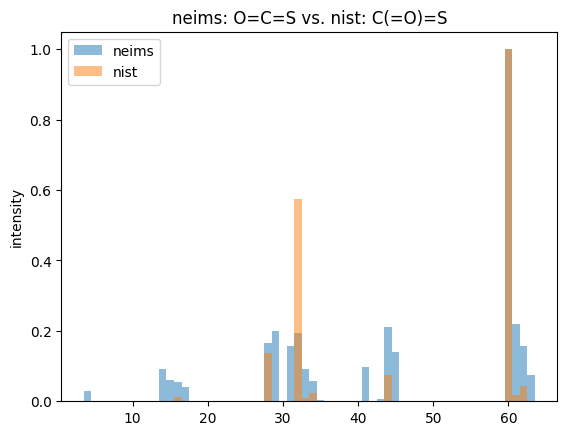

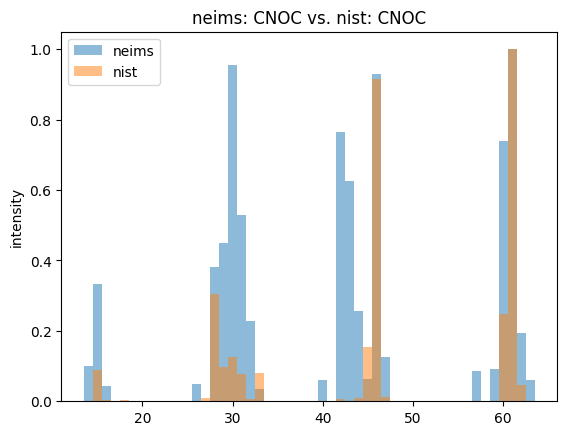

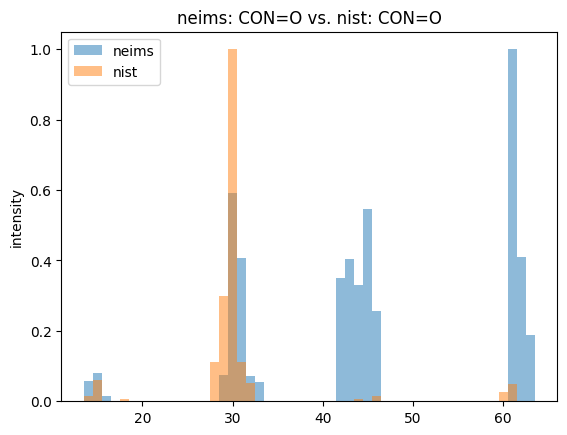

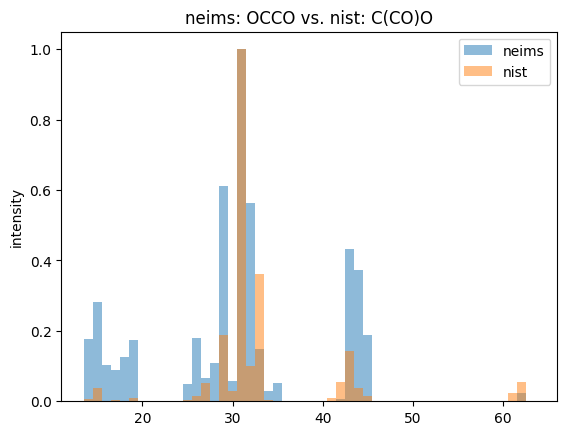

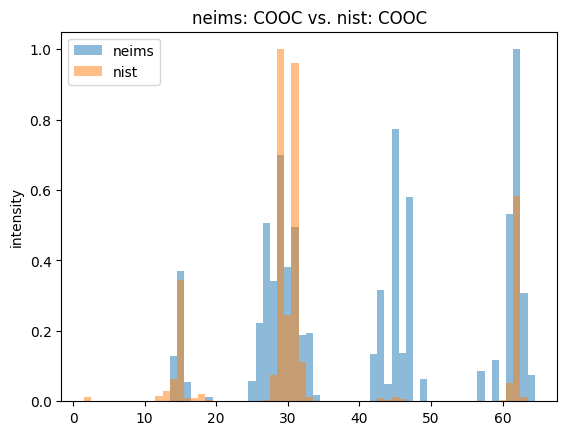

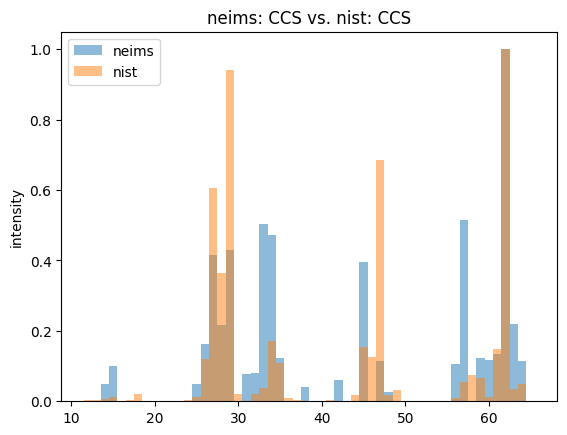

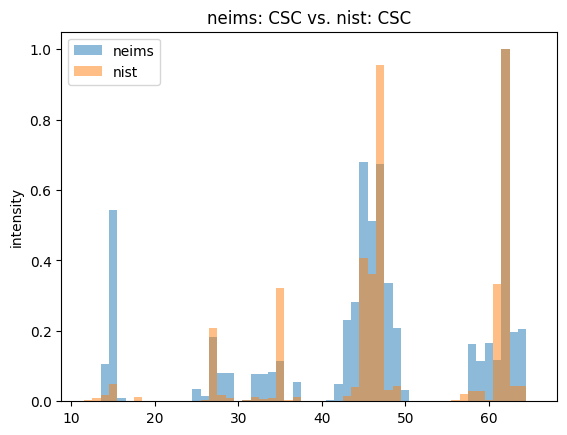

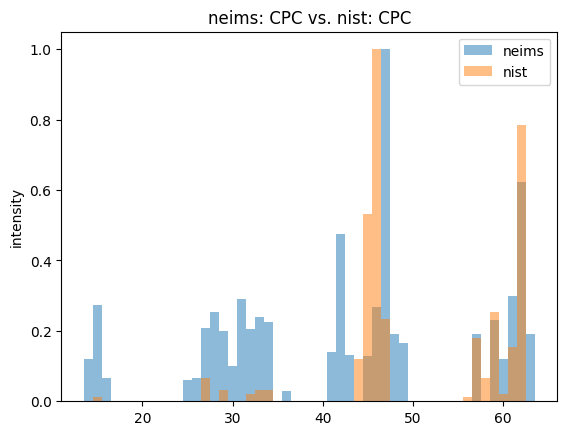

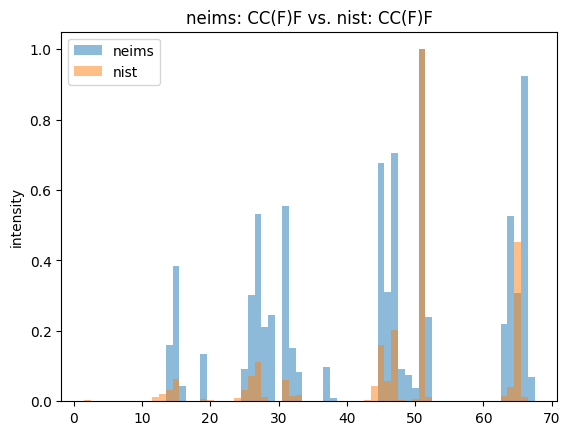

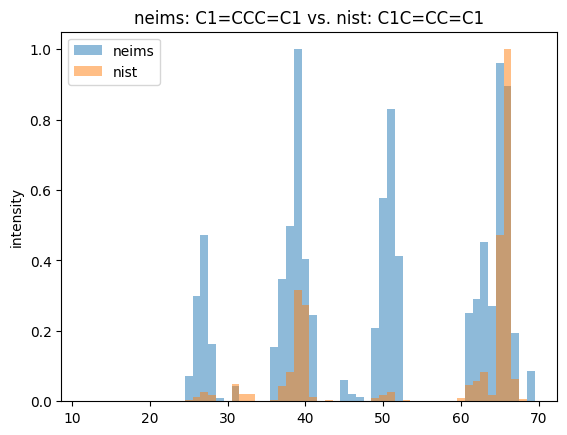

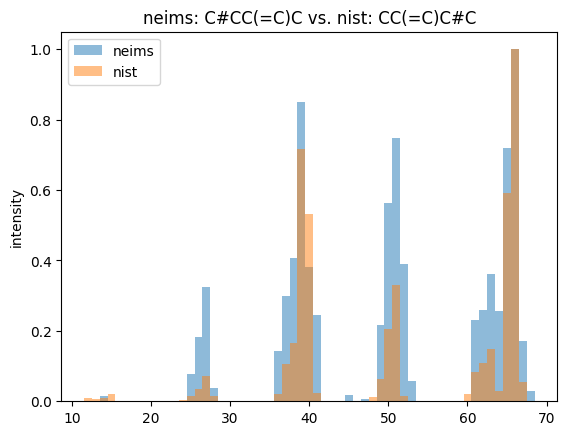

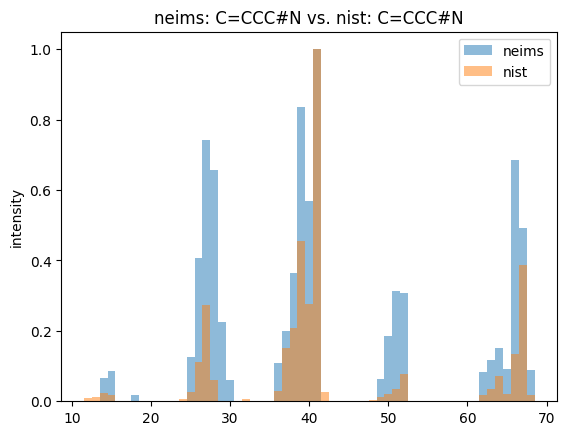

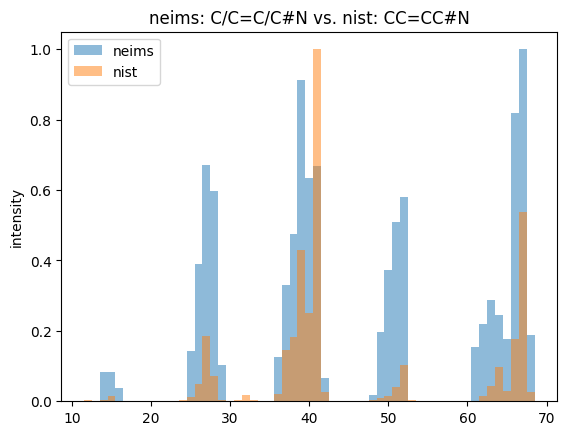

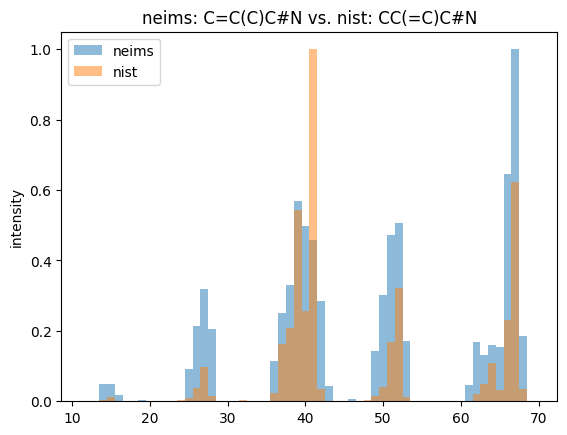

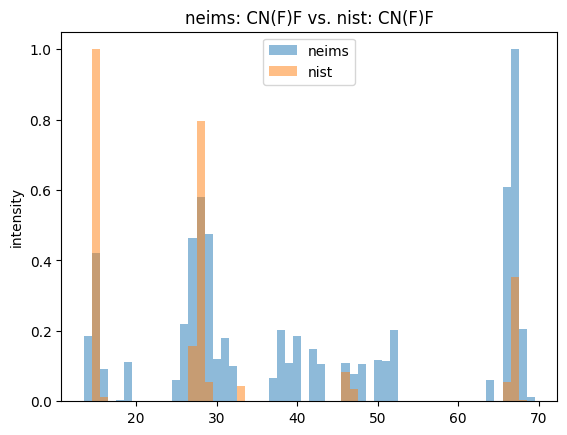

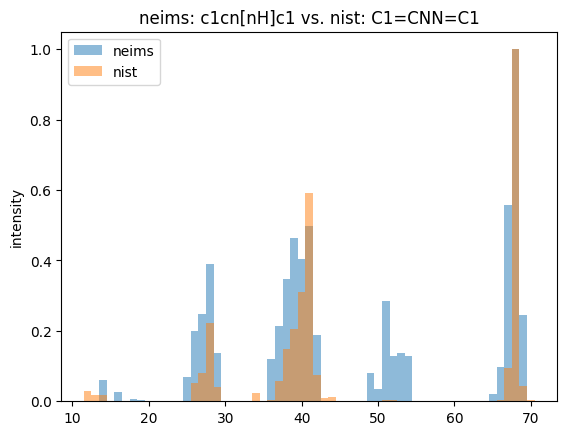

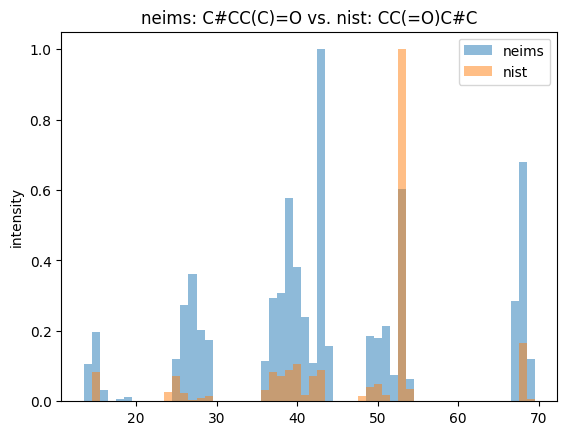

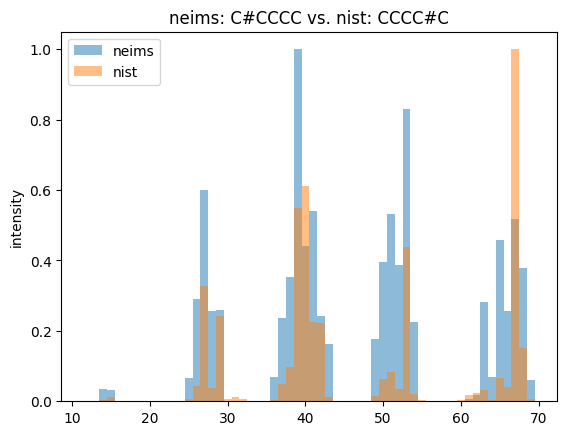

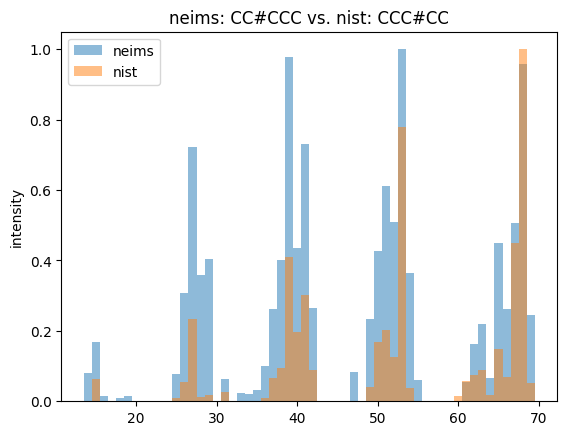

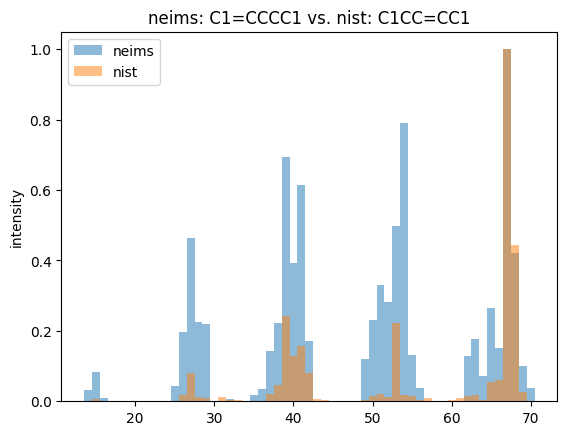

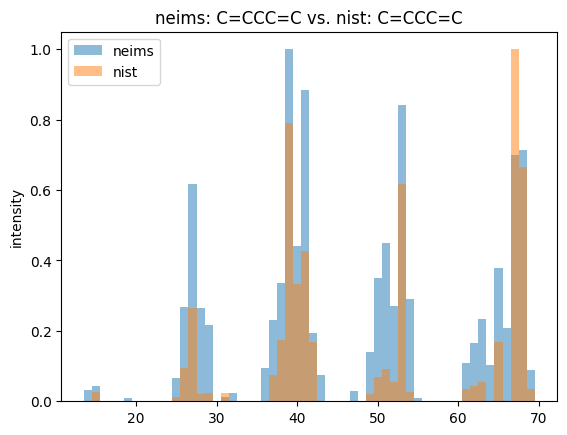

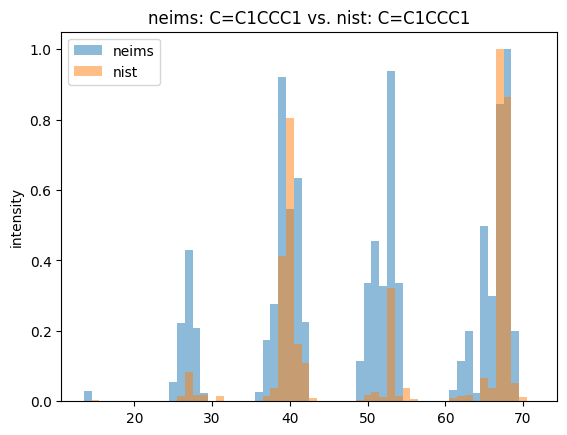

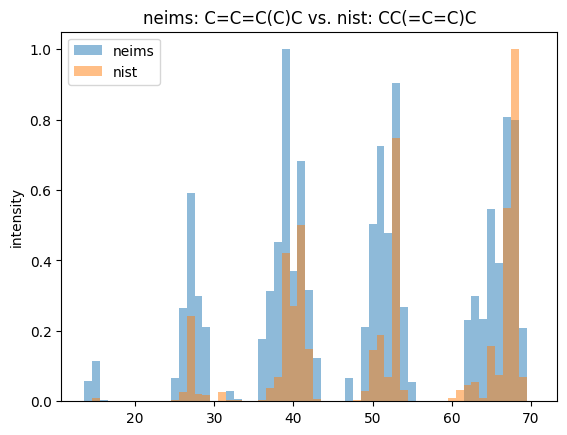

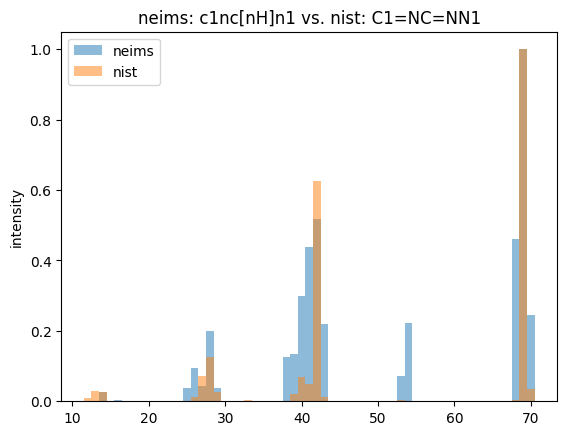

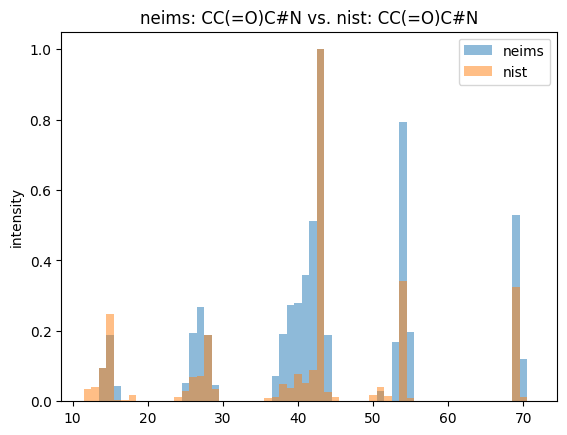

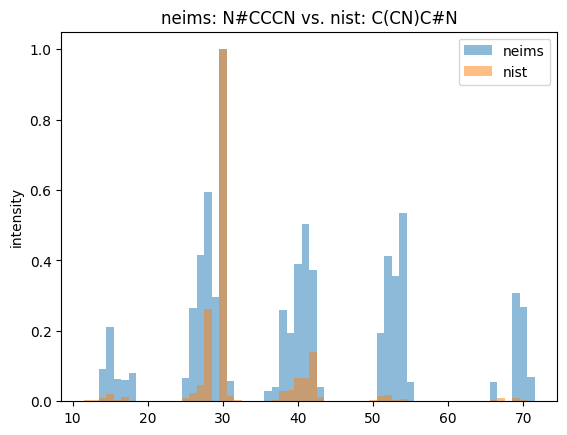

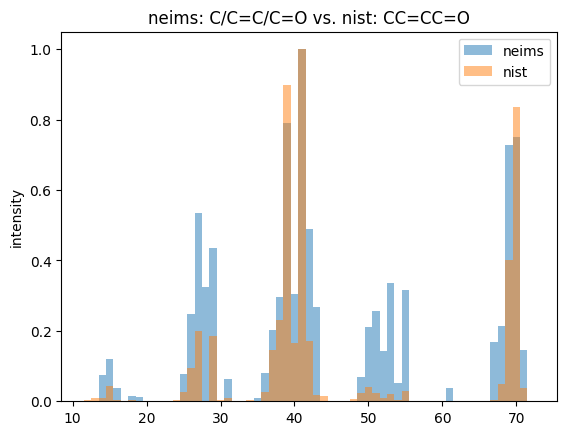

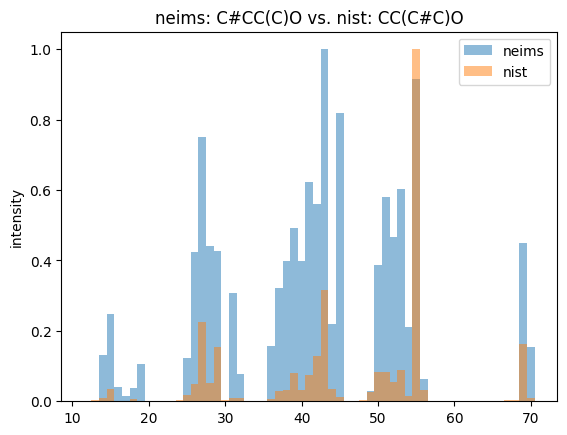

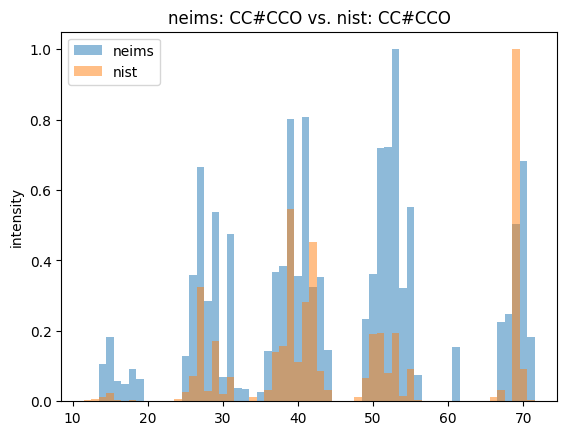

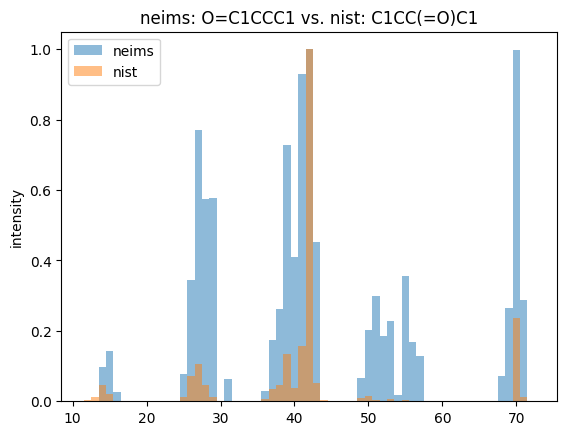

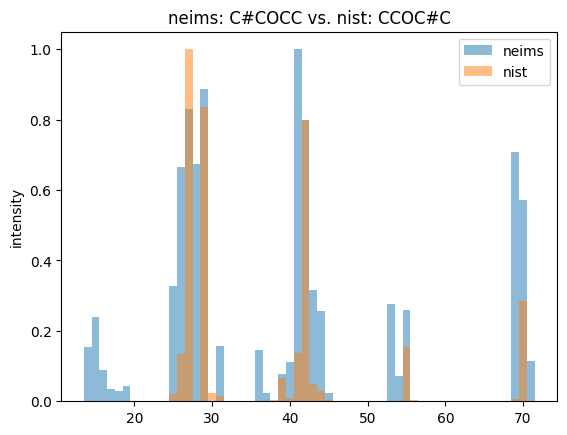

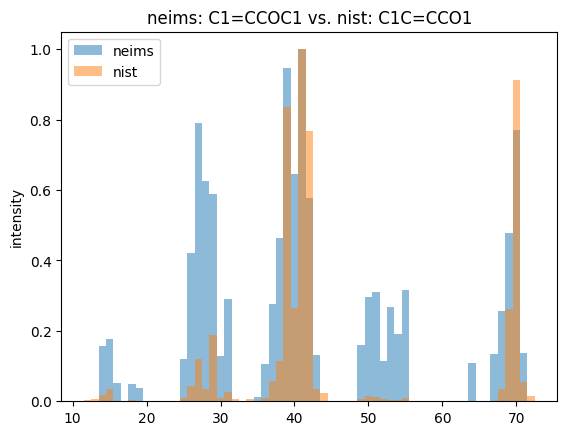

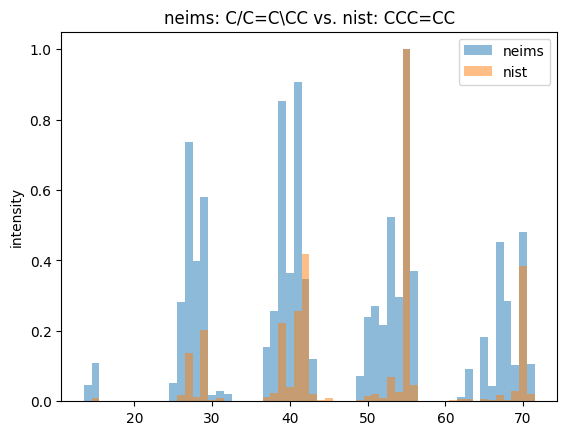

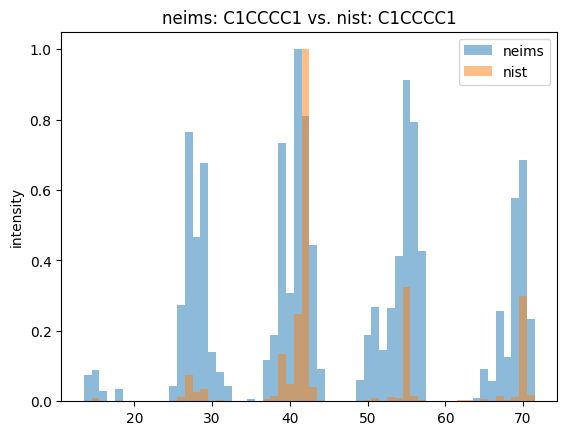

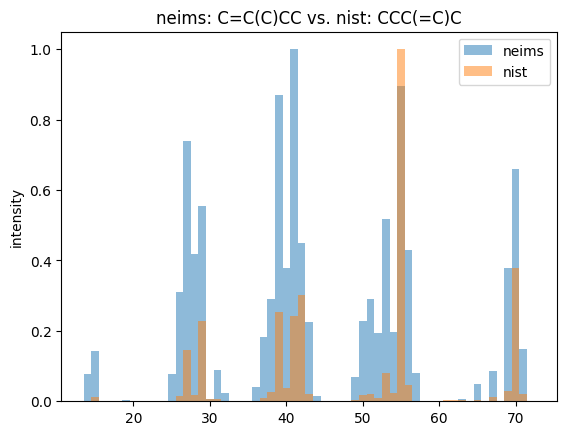

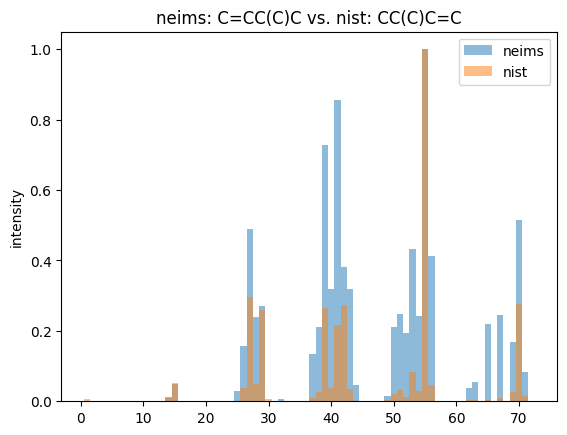

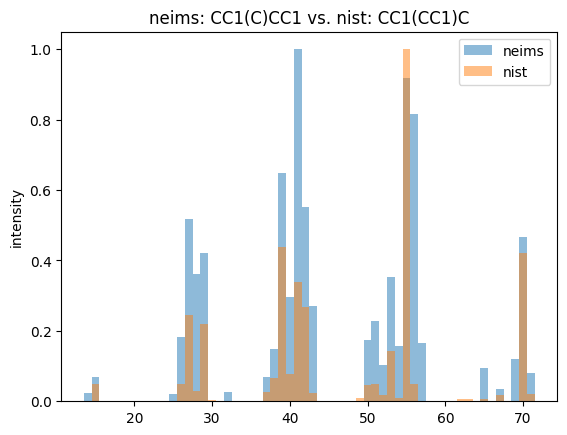

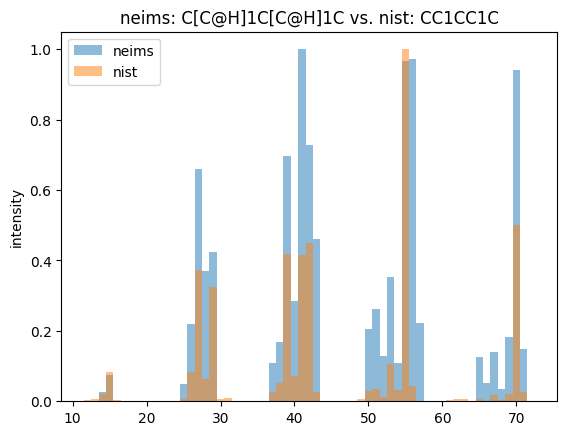

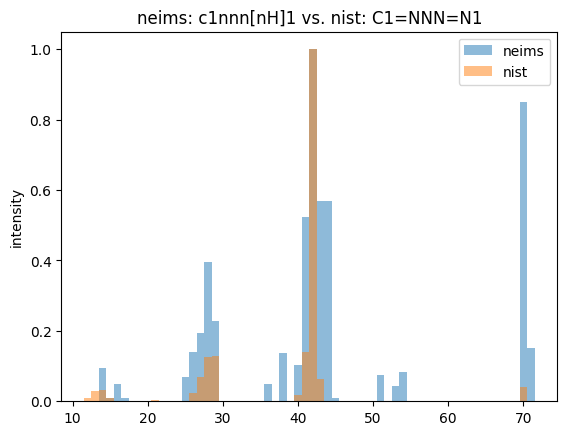

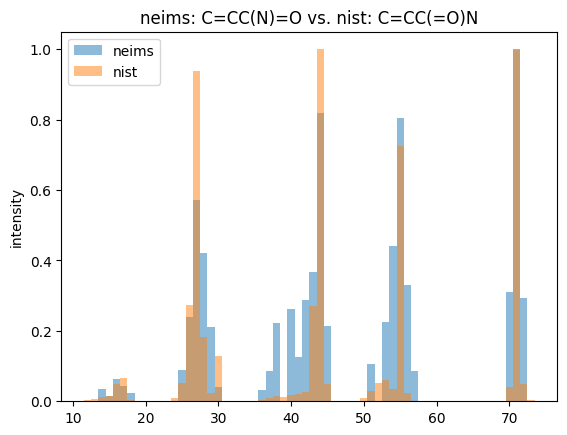

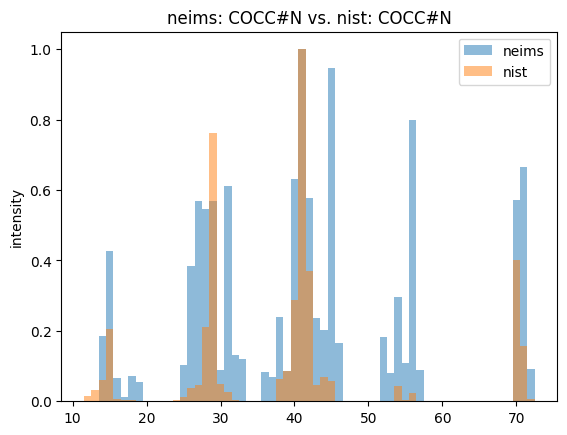

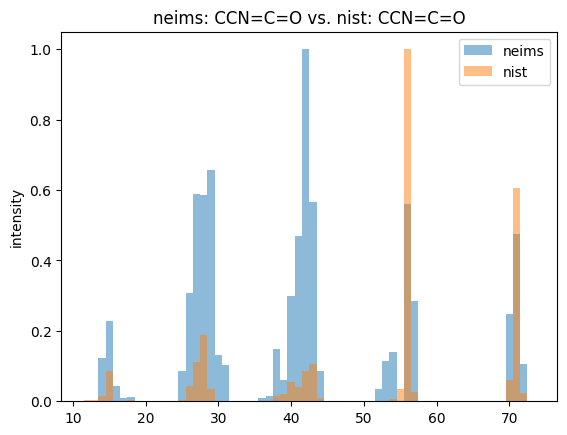

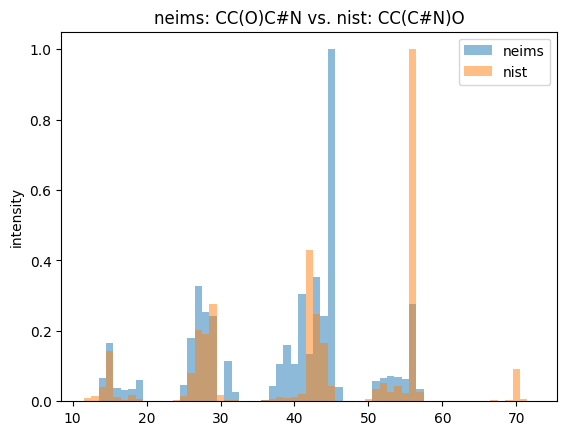

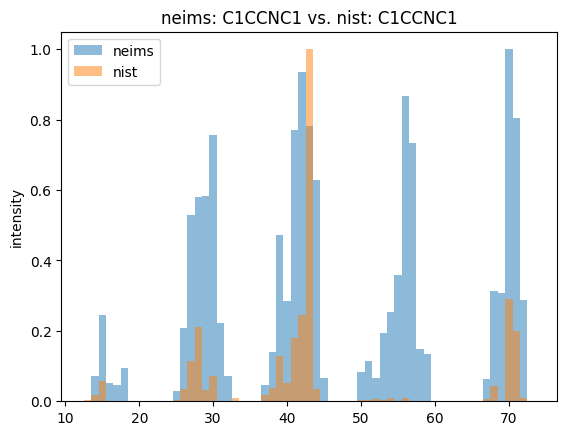

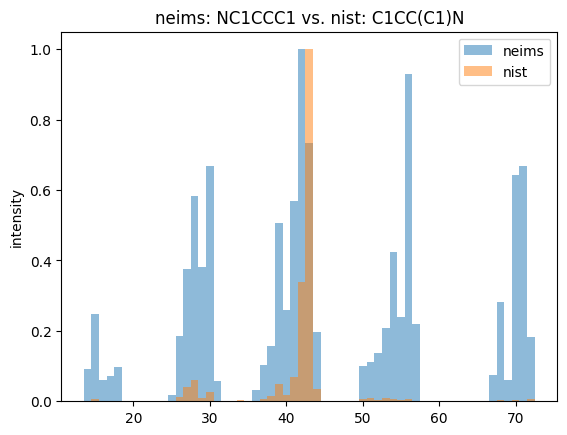

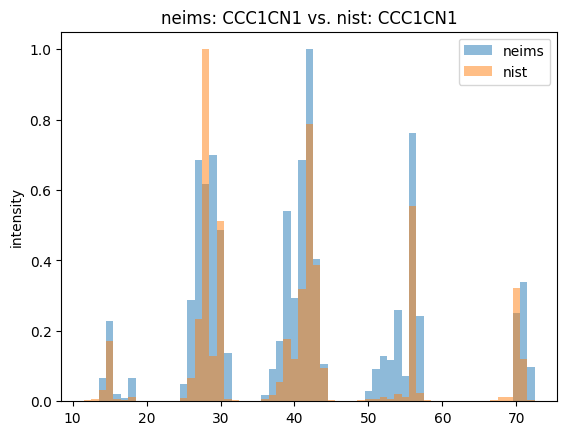

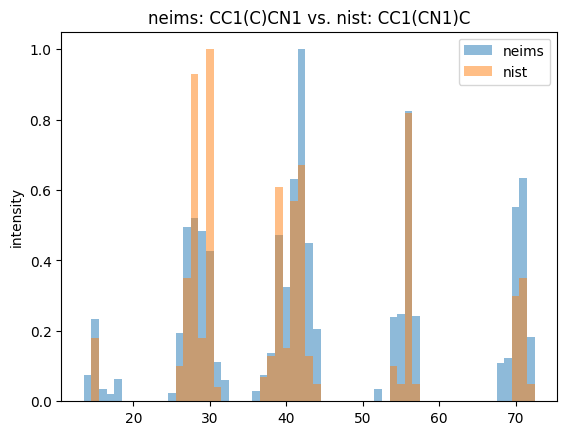

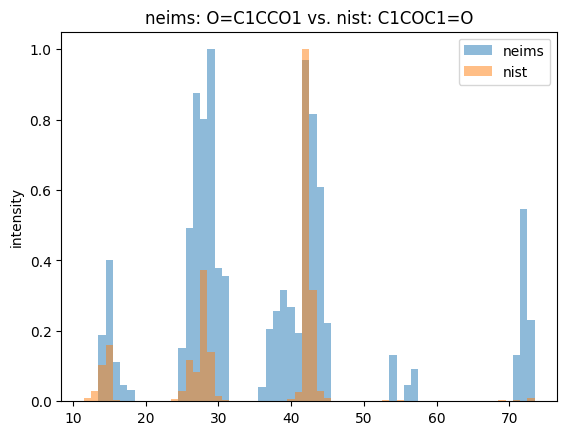

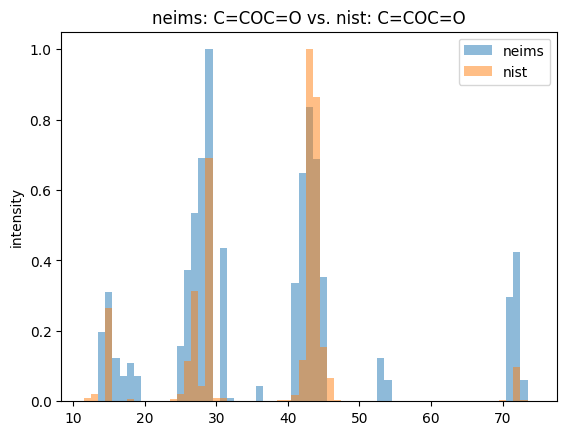

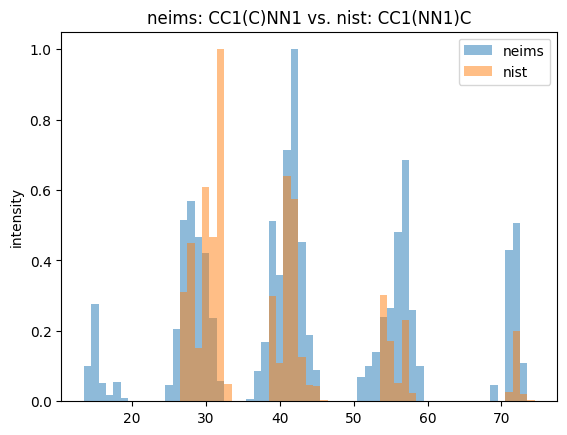

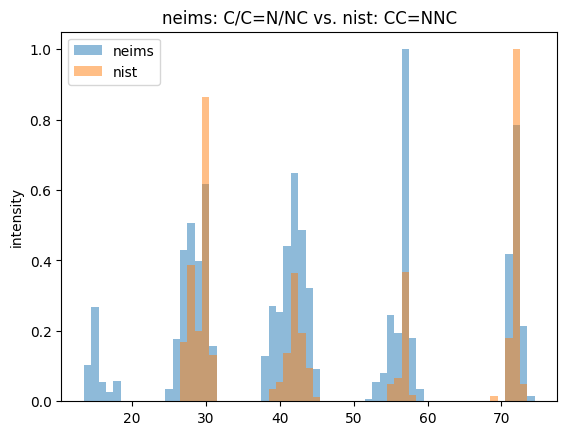

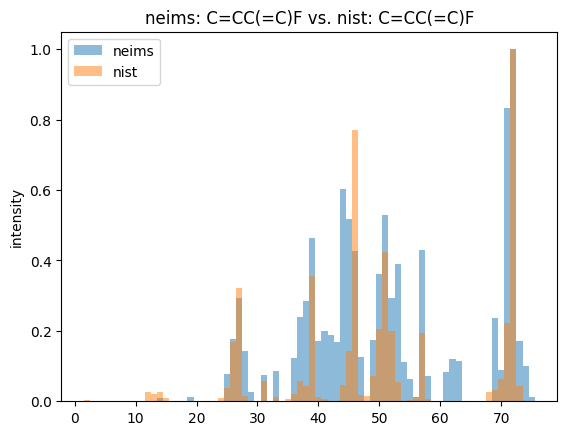

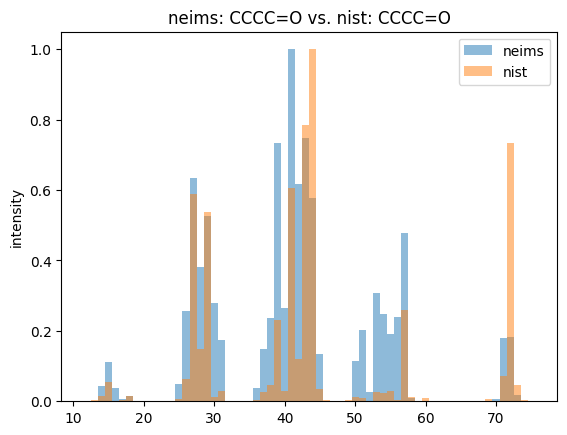

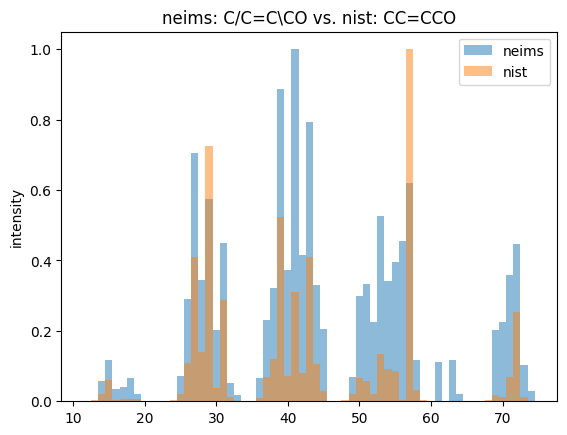

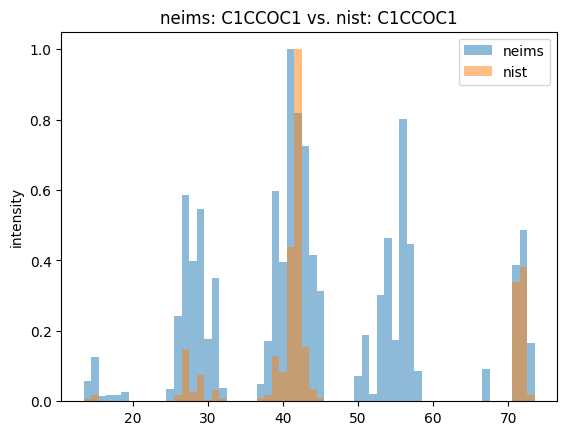

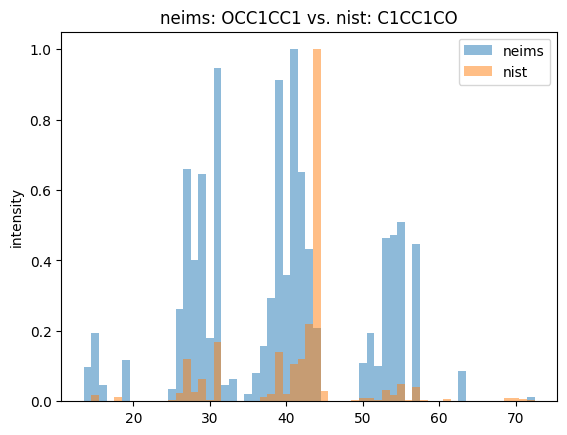

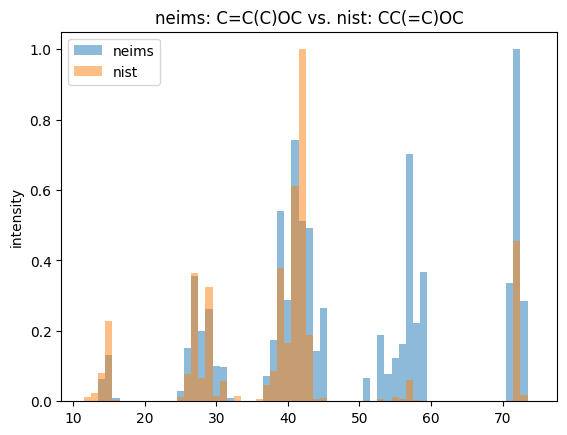

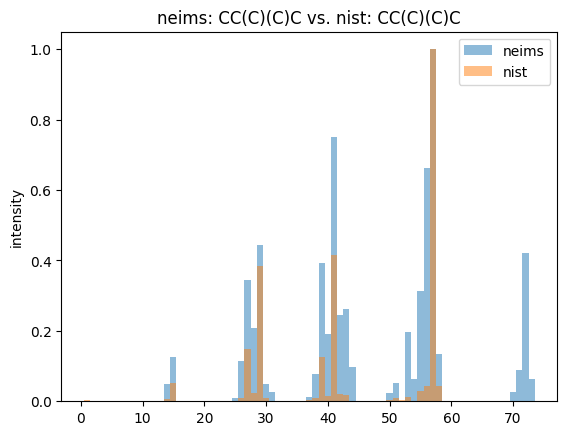

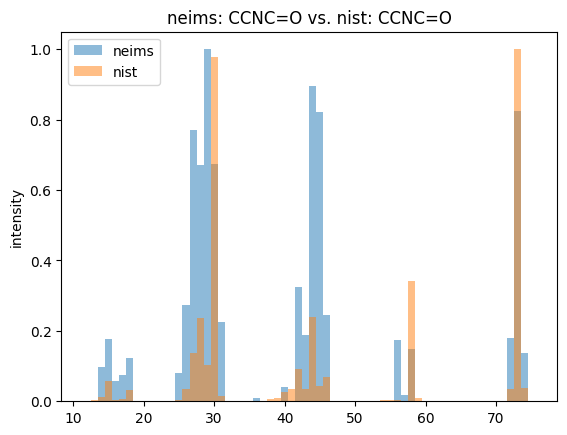

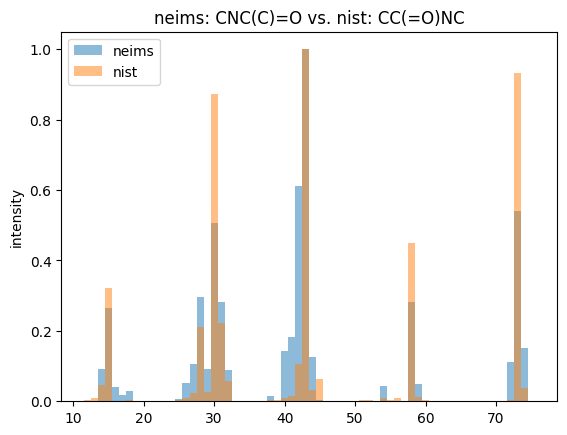

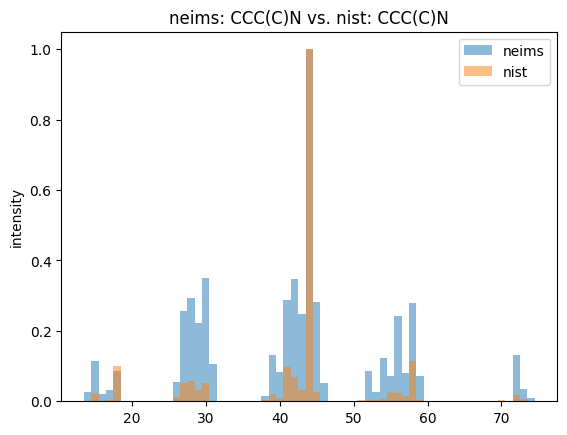

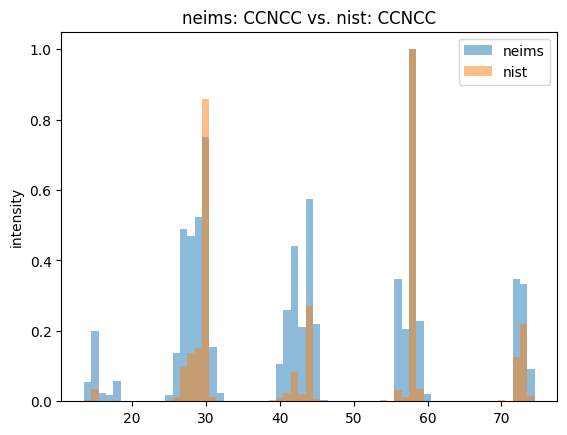

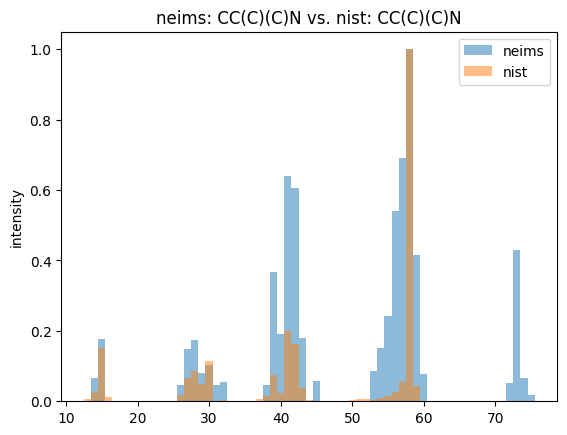

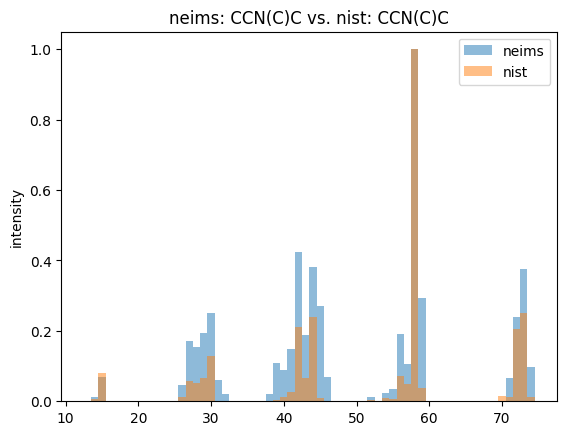

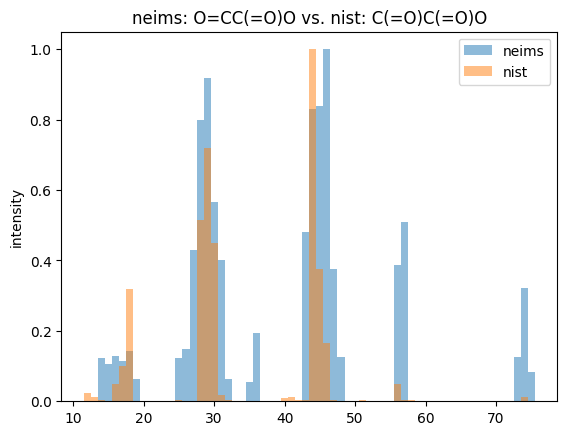

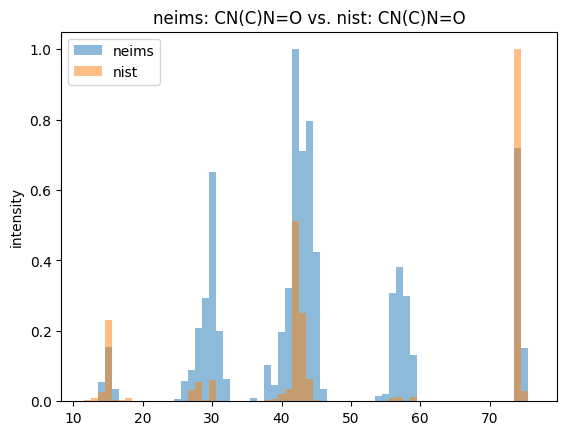

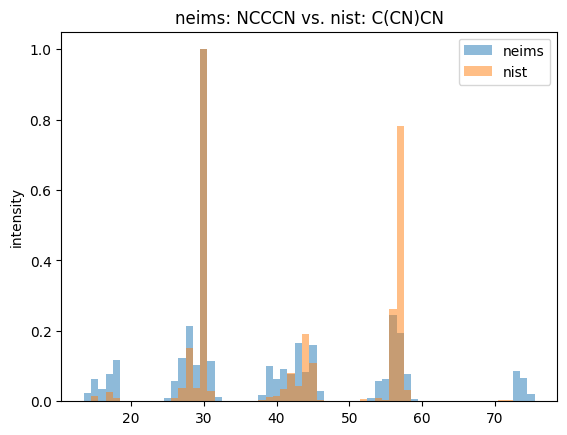

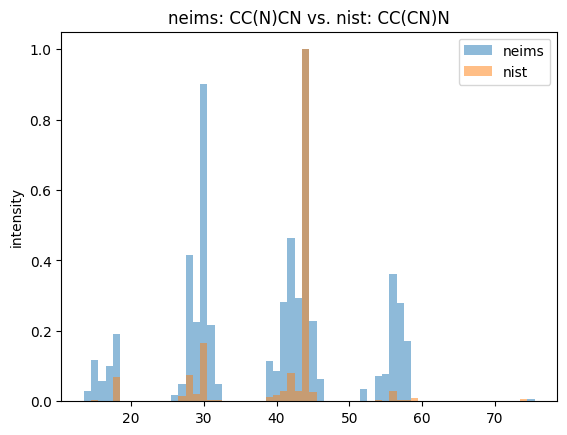

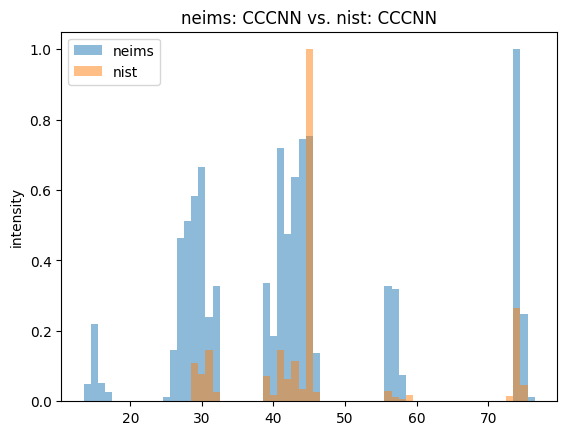

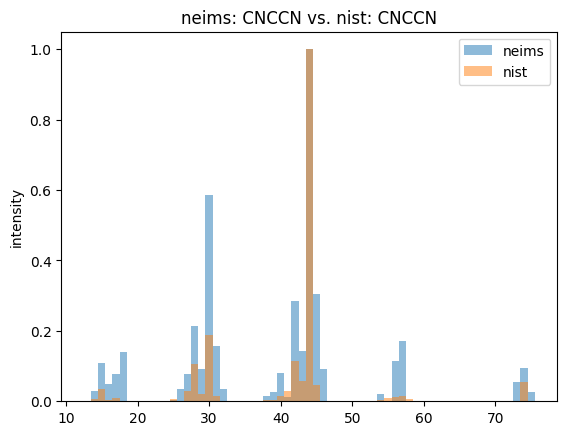

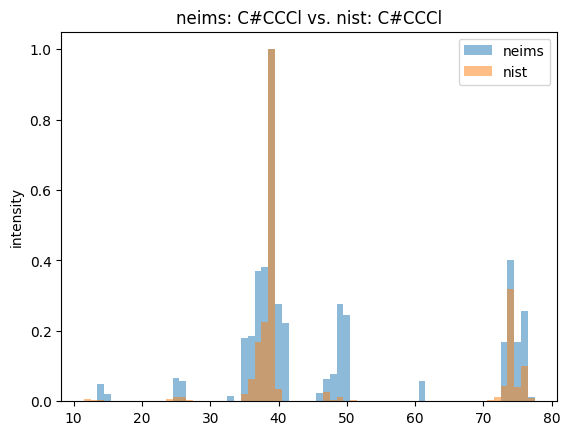

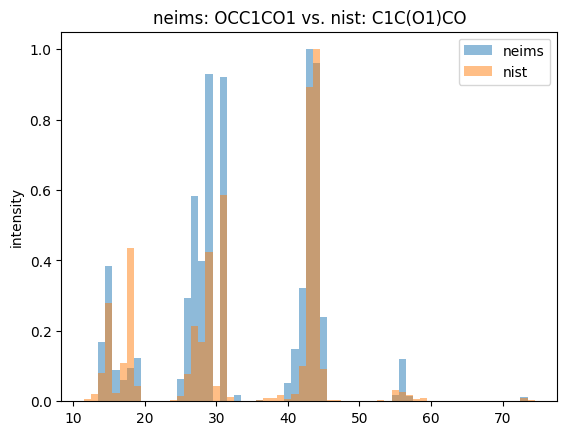

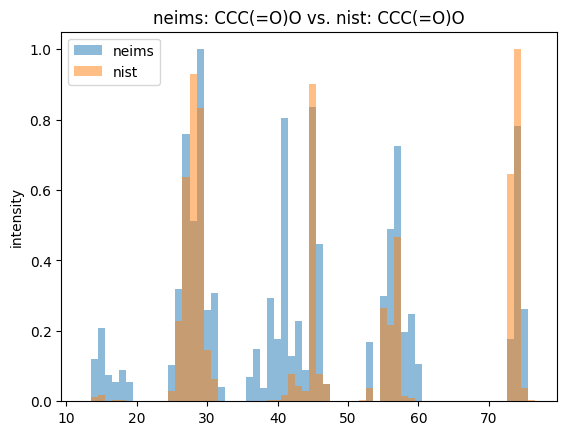

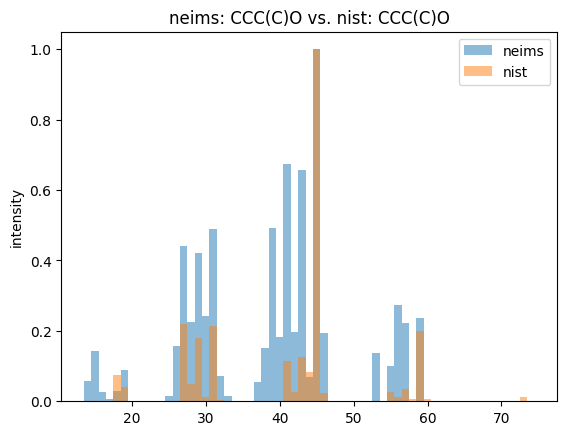

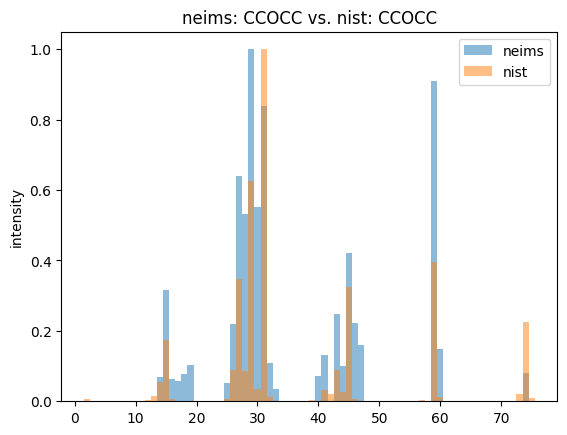

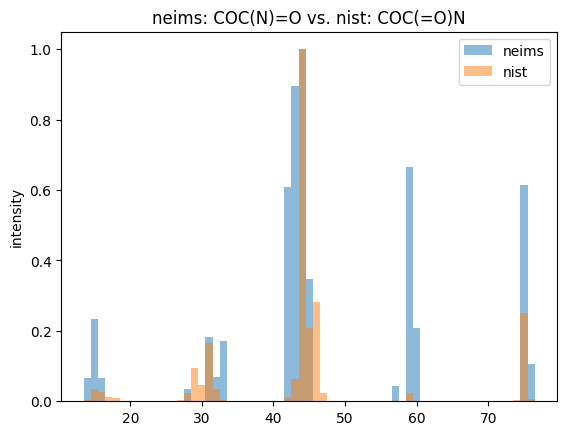

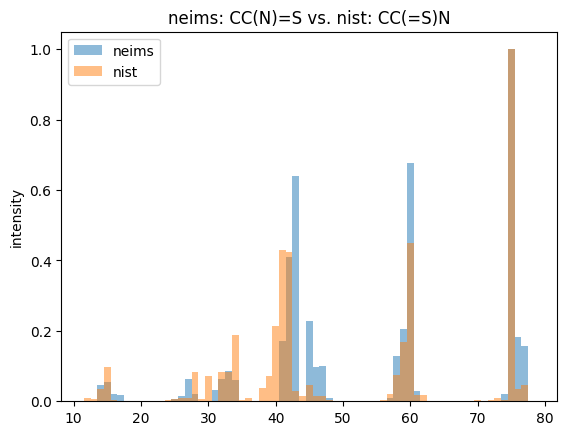

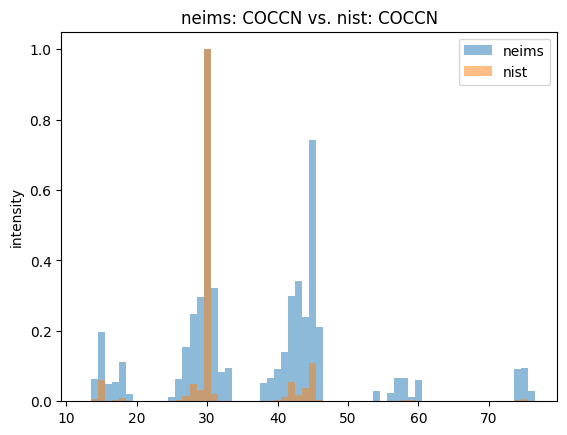

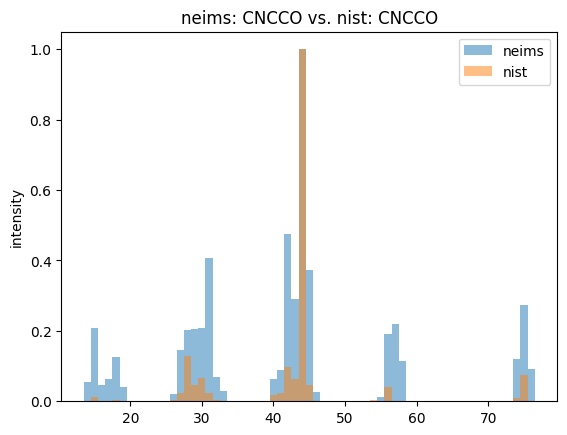

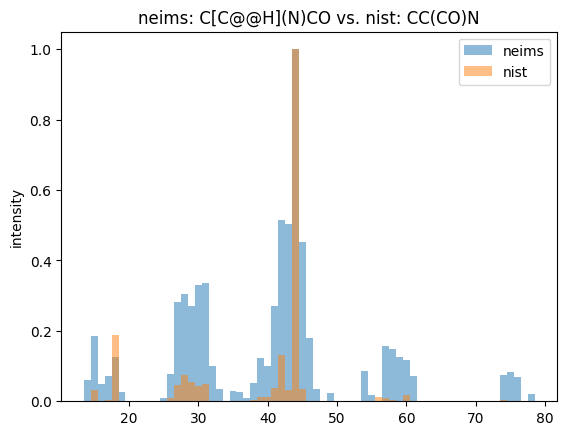

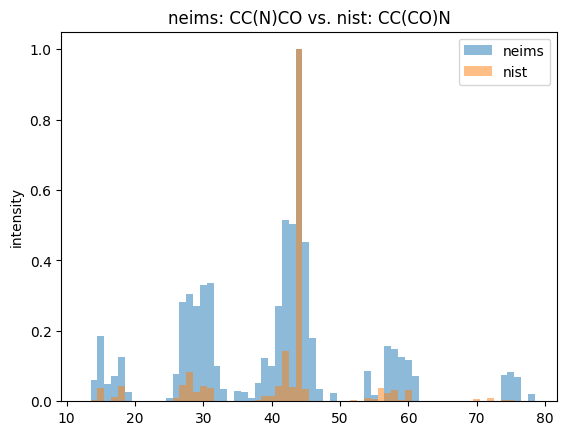

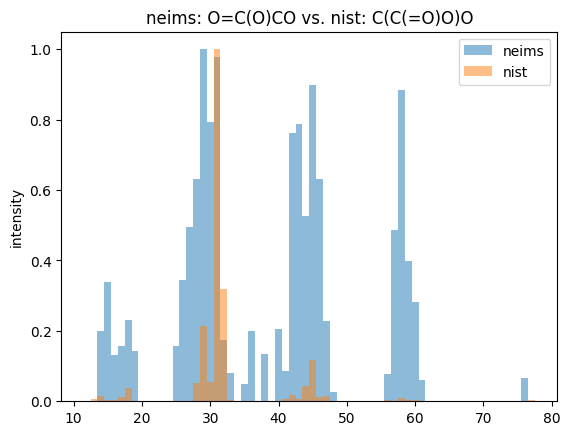

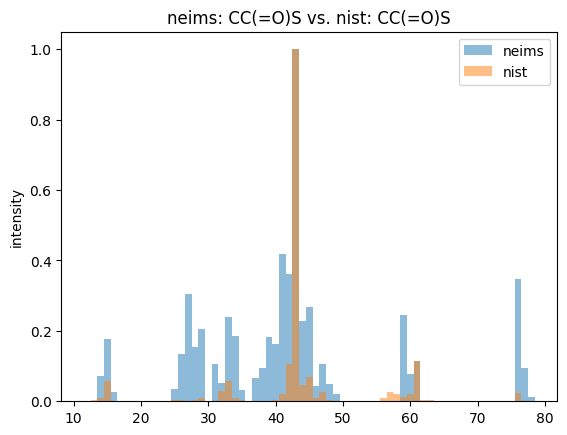

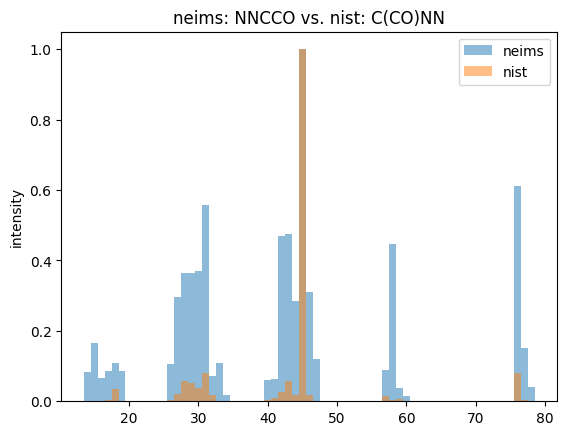

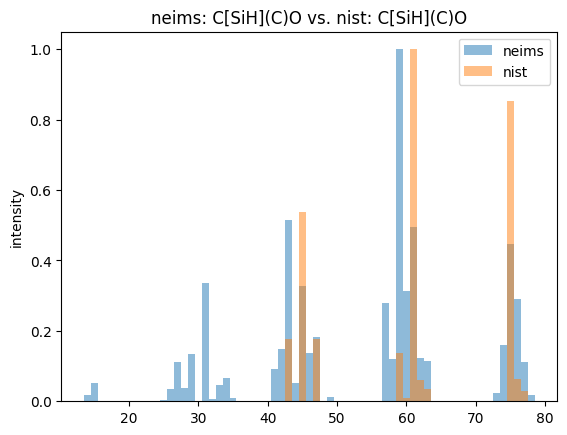

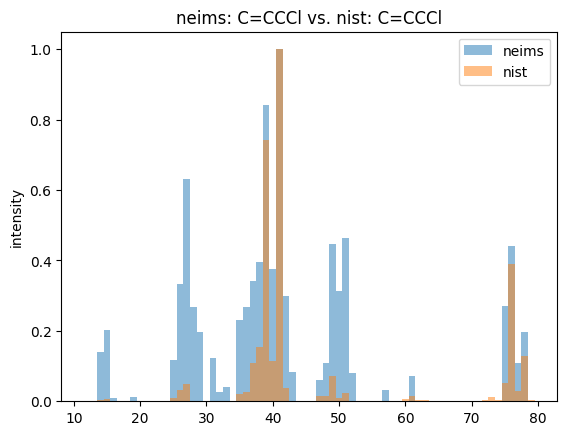

KeyboardInterrupt: 

In [19]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

def visualize_two_spectra(neims_spec, nist_spec):
    fig, ax = plt.subplots()
    ax.bar(neims_spec["mz"], height=neims_spec["intensity"], width=1, align='center', alpha=0.5, label="neims") #blue
    ax.bar(nist_spec["mz"], height=nist_spec["intensity"], width=1, align='center', alpha=0.5, label="nist") #orange
    # ax.xticks(y_pos, objects)
    ax.set_ylabel('intensity')
    ax.set_title(f'neims: {neims_spec["smiles"]} vs. nist: {nist_spec["smiles"]}')
    ax.legend()
    plt.show()

def visualize_two_spectra_1array(neims_arr, nist_arr):
    fig, ax = plt.subplots()
    ax.bar(range(len(neims_arr)), height=neims_arr, width=1, align='center', alpha=0.5, label="neims") #blue
    ax.bar(range(len(nist_arr)), height=nist_arr, width=1, align='center', alpha=0.5, label="nist") #orange
    # ax.xticks(y_pos, objects)
    ax.set_ylabel('intensity')
    ax.legend(["NEIMS", "NIST"])
#     ax.set_title(f'neims: {neims_spec["smiles"]} vs. nist: {nist_spec["smiles"]}')
    plt.show()
    
    
for i in neims_test_spec.keys():
    visualize_two_spectra(neims_test_spec[i], nist_test_spec[i])

## Compare the spectra

In [20]:
def visualize_two_bars_per_spec(neims_arr, nist_arr, x_labels, title=None):
    x = np.arange(len(x_labels))  # the label locations
    width = 0.45 # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 5.5)
    rects1 = ax.bar(x - width/2, neims_arr, width, label='neims')
    rects2 = ax.bar(x + width/2, nist_arr, width, label='nist')

    # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_ylabel('Num of peaks')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

### Visualize lengths of the spectra 

In [24]:
# tests, delete
neims_test_spec

{14: {'smiles': 'C=C',
  'mz': array([14, 15, 16, 18, 19, 25, 26, 27, 28, 29]),
  'intensity': array([0.05605606, 0.05305305, 0.01501502, 0.01601602, 0.05405405,
         0.17217217, 0.41041041, 1.        , 0.78678679, 0.11711712])},
 21: {'smiles': 'CC',
  'mz': array([14, 15, 25, 26, 27, 28, 29, 30, 31, 32]),
  'intensity': array([0.27527528, 0.66566567, 0.11211211, 0.46946947, 0.98998999,
         0.76176176, 0.8018018 , 1.        , 0.43543544, 0.11211211])},
 29: {'smiles': 'CN',
  'mz': array([14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36]),
  'intensity': array([0.25925926, 0.44444444, 0.18318318, 0.08008008, 0.08608609,
         0.07407407, 0.14014014, 0.36736737, 0.62162162, 0.76576577,
         0.66266266, 0.59459459, 1.        , 0.28928929, 0.09409409,
         0.09409409])},
 35: {'smiles': 'NN',
  'mz': array([14, 15, 16, 17, 18, 19, 25, 26, 28, 29, 30, 31, 32, 33]),
  'intensity': array([0.07307307, 0.04704705, 0.17617618, 0.11411411, 0.05305305,
         

In [25]:
labels = list(neims_test_spec.keys())

In [26]:
neims_lens = np.array([len(neims_test_spec[key]["mz"]) for key in neims_test_spec.keys()])

In [27]:
nist_lens = np.array([len(nist_test_spec[key]["mz"]) for key in nist_test_spec.keys()])

In [28]:
max(neims_lens)

476

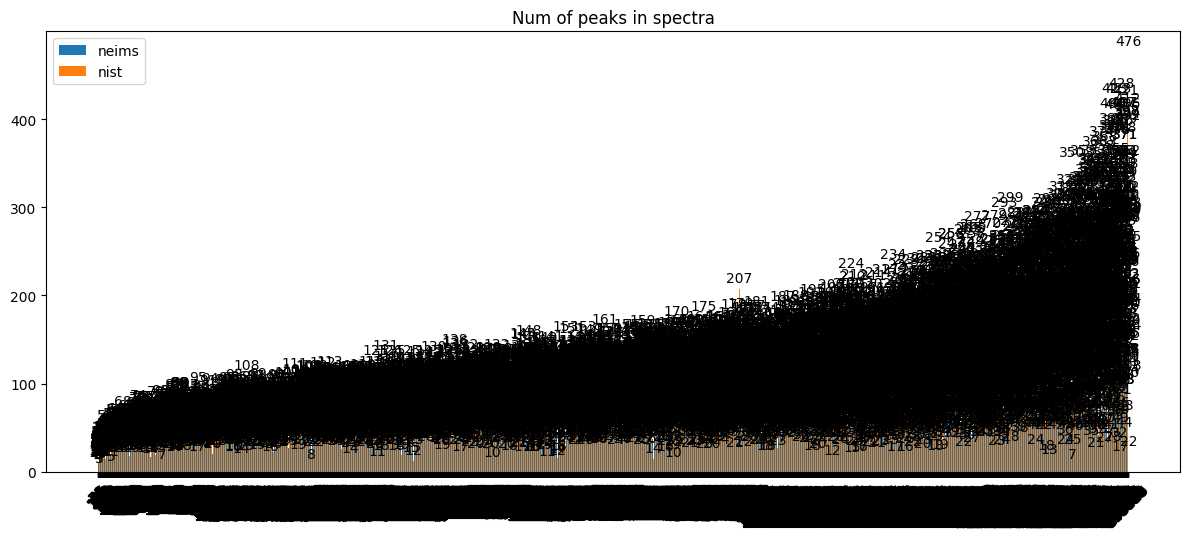

In [29]:
visualize_two_bars_per_spec(neims_lens, nist_lens, labels, title="Num of peaks in spectra")

In [ ]:
# the things above this are one cell

In [ ]:
# spectra with more than n peaks
n = 150
print(f"NIST spectra with more than {n} peaks:  ", sum(nist_lens > n))
print(f"NEIMS spectra with more than {n} peaks: ", sum(neims_lens > n))

sum(np.any([neims_lens > n, nist_lens > n], axis=0))

In [ ]:
nist_over100 = [x for x in neims_lens if x > 100]
neims_over100 = [x for x in nist_lens if x > 100]
print(f"Num of spectra with more than 100 peaks in NIST: {len(nist_over100)}\nrate: {len(nist_over100)/len(nist_lens)}")
print(f"Num of spectra with more than 100 peaks in NEIMS: {len(neims_over100)}\nrate: {len(neims_over100)/len(neims_lens)}")

### Visualize peak sums of the spectra 

In [ ]:
labels = list(neims_test_spec.keys())
neims_lens = [round(sum(neims_test_spec[key]["intensity"]), 2) for key in neims_test_spec.keys()]
nist_lens = [round(sum(nist_test_spec[key]["intensity"]), 2) for key in nist_test_spec.keys()]

visualize_two_bars_per_spec(neims_lens, nist_lens, labels, title="Sum of the normalized intensities")

## Compare NIST's and NEIMS's mzs sorted by intensity

QUESTION: How many of the first n biggest peaks correspond/overlap

In [26]:
# check wether there are duplicities in the intensities (print according ids)
# only to see, the intens. are quite long ints
# for key in neims_test_spec.keys():
#     counter = Counter(neims_test_spec[key]["intensity"])
#     if len(counter.values()) != sum(counter.values()):

In [27]:
# create nist and neims spectra that do not have mz, only 0 on positions that have zero
def put_spectra_to_one_array(data):
    for id_, spec in data.items():
#         print(spec)
        mzs = spec["mz"]
        ints = spec["intensity"]
        max_ = mzs.max()
        new_spec = np.zeros(max_+1)
        for i in range(len(mzs)):
            new_spec[mzs[i]] = ints[i]
        data[id_]["spectrum"] = new_spec
    return data

# toto by se mozna hodilo dat vys rovnou -_o_-
neims_test_spec = put_spectra_to_one_array(neims_test_spec)
nist_test_spec = put_spectra_to_one_array(nist_test_spec)        

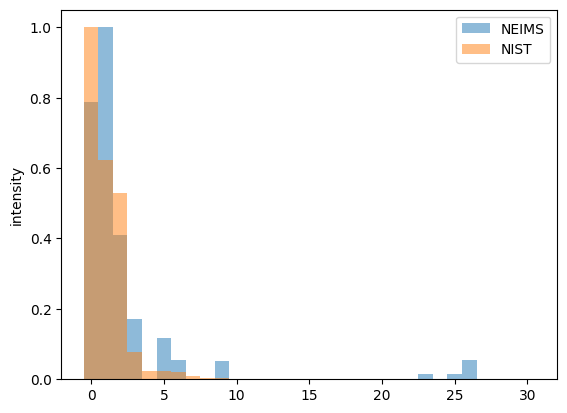

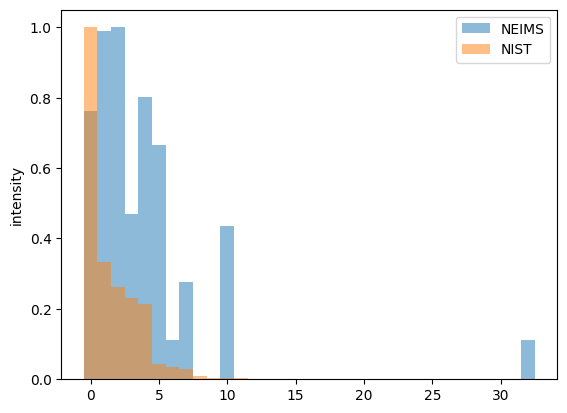

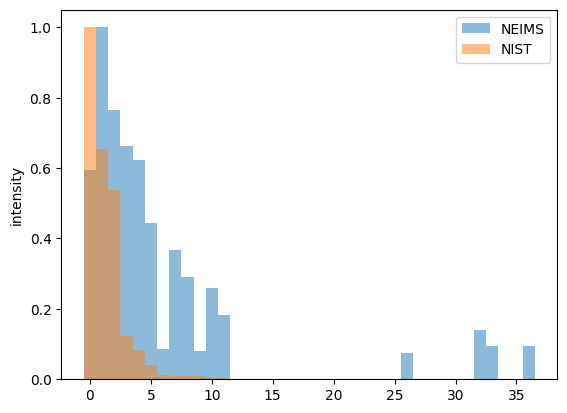

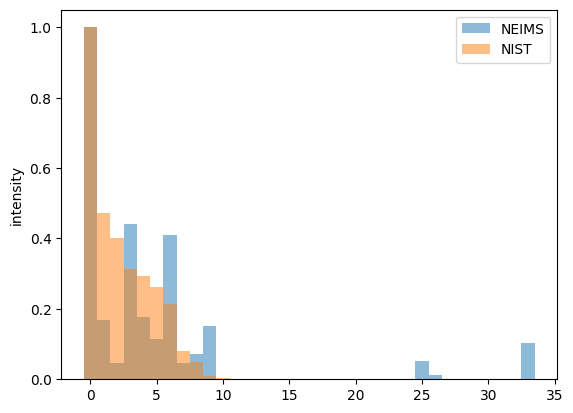

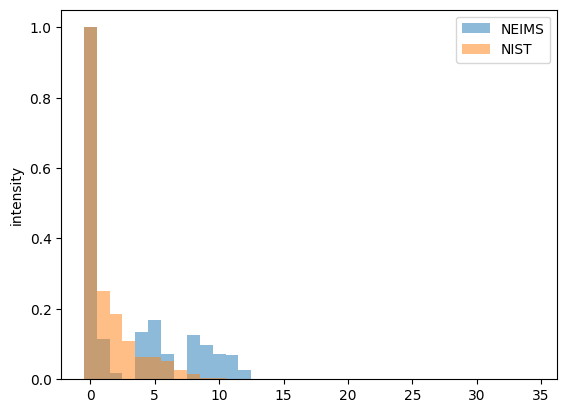

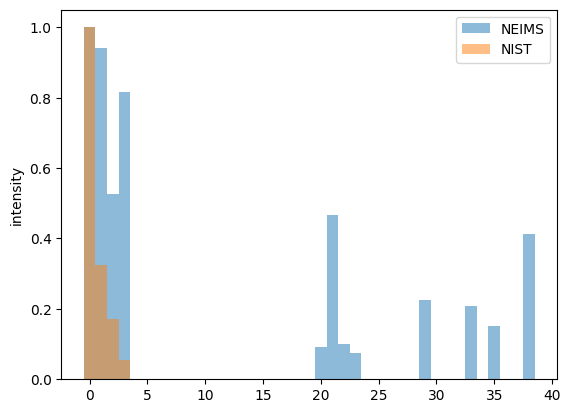

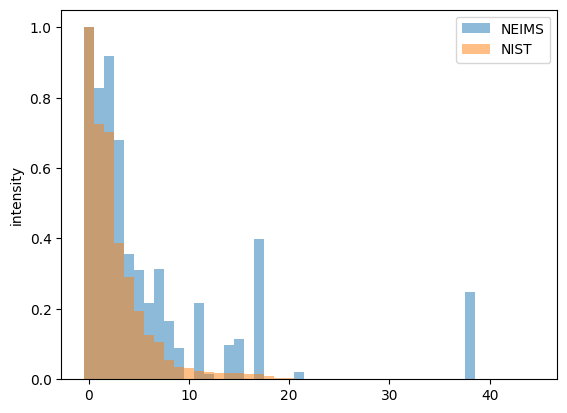

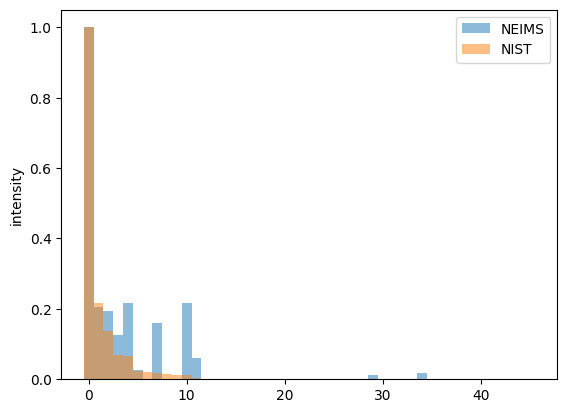

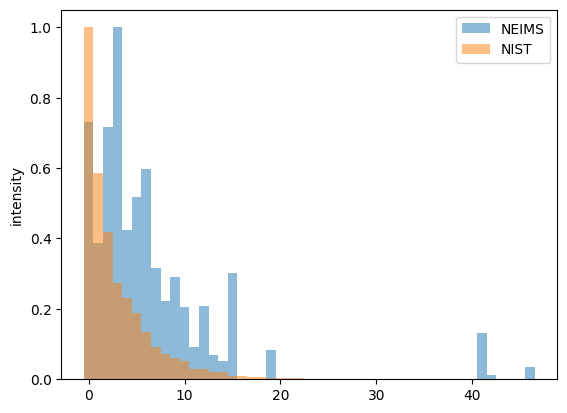

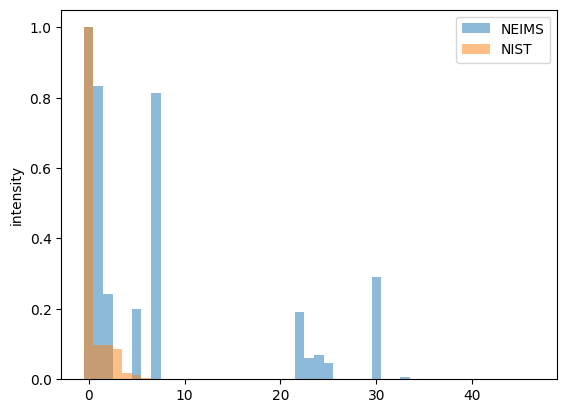

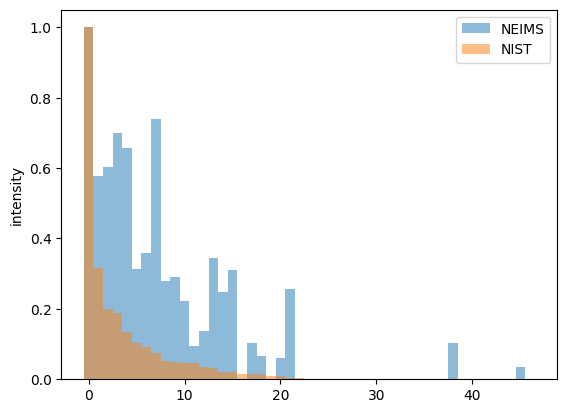

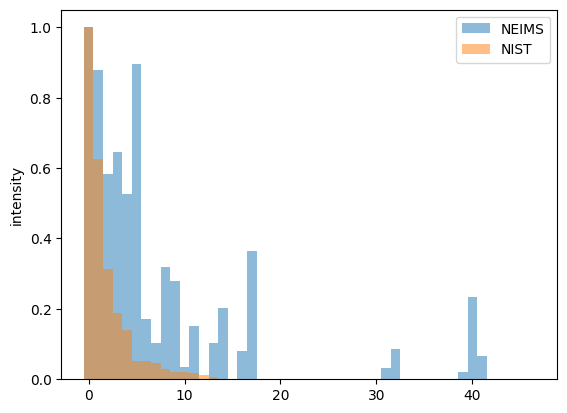

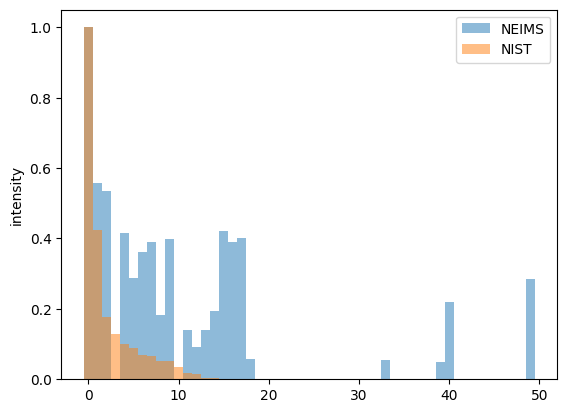

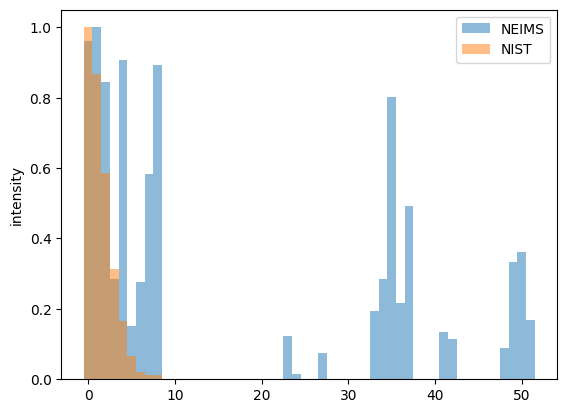

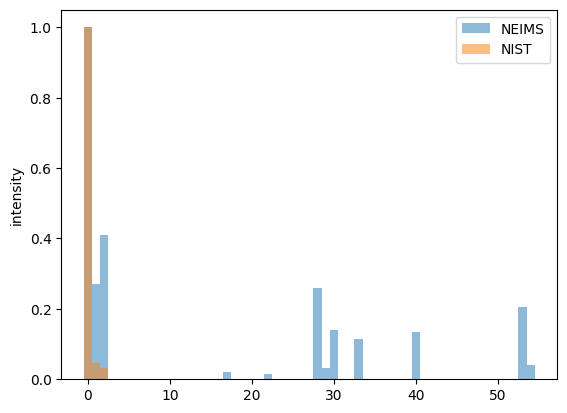

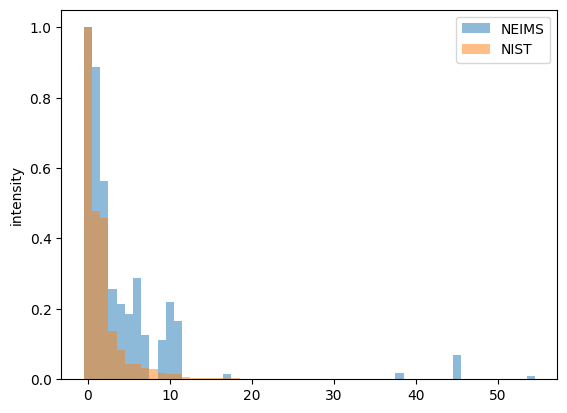

KeyboardInterrupt: 

In [30]:
# take neims and nist corresponding spectra and enlong one of them to fit the other (with zeros)
# sort both according to the NIST. You can plot it I guess
def get_sorted_mzs(nist_arr, neims_arr):
    # pad the arrays
    neims_l = neims_arr.shape[0]
    nist_l = nist_arr.shape[0]
    if nist_l < neims_l:
        nist_arr = np.pad(nist_arr, (0, neims_l - nist_l))
    else: 
        neims_arr = np.pad(neims_arr, (0, nist_l - neims_l))
    zipped = list(zip(nist_arr, neims_arr))
    zipped.sort(key=lambda x : x[0], reverse=True)
    
    nist_arr = [x for x,y in zipped]
    neims_arr = [y for x,y in zipped]
    
    return nist_arr, neims_arr

for key in nist_test_spec.keys():
    nist_arr, neims_arr = get_sorted_mzs(nist_test_spec[key]["spectrum"], neims_test_spec[key]["spectrum"])
    visualize_two_spectra_1array(neims_arr, nist_arr)

## Measure the peak overlap in the n biggest peaks

In [30]:
# extract n biggest mzs according to intensities and compute the overlap
def compute_overlap(neims_spec, nist_spec, n):
    zipped_nist = sorted(list(zip(nist_spec["mz"], nist_spec["intensity"])), key=lambda x : x[1], reverse=True)
    zipped_neims = sorted(list(zip(neims_spec["mz"], neims_spec["intensity"])), key=lambda x : x[1], reverse=True)
    
    n_mzs_nist = np.array([x for x,y in zipped_nist])[:min(n, len(zipped_nist))]
    n_mzs_neims = np.array([x for x,y in zipped_neims])[:min(n, len(zipped_neims))]
    overlap_size = sum(np.isin(n_mzs_nist, n_mzs_neims))
    return overlap_size, min(n_mzs_nist.shape[0], n_mzs_neims.shape[0])

def visualize_overlap(base_data, olap_data, n, title=None):
    overlaps = [compute_overlap(olap_data[k1],base_data[k2], n) for k1, k2 in list(zip(neims_test_spec.keys(),  nist_test_spec.keys()))]
    #print(overlaps)
    olap_arr = [x for x,_ in overlaps]
    base_arr = [y for _,y in overlaps]    
    
    x_labels = neims_test_spec.keys()
    xx = range(len(x_labels))
    bar_width = 0.5
    
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 5.5, forward=True)
    
    ax.bar(xx, height=olap_arr, width=bar_width, align='center', alpha=0.5, label="neims") #blue
    rects = ax.bar(xx, height=base_arr, width=bar_width, align='center', alpha=0.5, label="nist") #orange
    ax.set_title(title)
    ax.set_xlabel('spec IDs')
    ax.set_ylabel('overlapped peaks')
    ax.set_xticks(xx)
    ax.set_xticklabels(x_labels, rotation=45)
    
    # display label above nist bars
    for i in range(len(rects)):
        ax.annotate('{}/{}'.format(olap_arr[i], base_arr[i]),
                    xy=(i, base_arr[i]),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    ax.legend(["overlapped", f"min(n, num of peaks)"])
    plt.show()
    
n = 20
# make the sets smaller - like this it doesn't make sense
# visualize_overlap(nist_test_spec, neims_test_spec, n, title=f"Number of overlapped peaks between the two sets considering up to {n} biggest") 

In [31]:
# the overlap data in text form    
for key in neims_test_spec.keys():
    overlapped, out_of = compute_overlap(neims_test_spec[key], nist_test_spec[key], 20)
    smiles = nist_test_spec[key]["smiles"]
    print(f'id: {key}, smiles: {nist_test_spec[key]["smiles"]}, overlaps: {overlapped}/{out_of}')

id: 14, smiles: C=C, overlaps: 7/10
id: 21, smiles: CC, overlaps: 9/10
id: 29, smiles: CN, overlaps: 12/13
id: 35, smiles: NN, overlaps: 10/11
id: 40, smiles: NO, overlaps: 11/11
id: 48, smiles: Cl, overlaps: 4/4
id: 60, smiles: CC=C, overlaps: 15/17
id: 73, smiles: C(=N)=O, overlaps: 9/11
id: 87, smiles: CCC, overlaps: 17/20
id: 90, smiles: C(=O)=O, overlaps: 5/8
id: 95, smiles: CCN, overlaps: 18/20
id: 97, smiles: CNC, overlaps: 16/18
id: 120, smiles: CON, overlaps: 17/19
id: 127, smiles: CP, overlaps: 9/9
id: 135, smiles: C(#N)C#N, overlaps: 3/3
id: 137, smiles: C=CC#C, overlaps: 12/15
id: 143, smiles: C=CC#N, overlaps: 16/19
id: 152, smiles: CCC#C, overlaps: 17/20
id: 153, smiles: CC#CC, overlaps: 16/18
id: 158, smiles: C=CC=C, overlaps: 15/20
id: 168, smiles: CCC#N, overlaps: 17/20
id: 169, smiles: C#CCN, overlaps: 17/20
id: 179, smiles: C(C#N)N, overlaps: 16/20
id: 193, smiles: CC=CC, overlaps: 18/20
id: 199, smiles: C1CCC1, overlaps: 18/20
id: 201, smiles: CC=CC, overlaps: 19/20

### Visualize mean overlap rate dependent on n

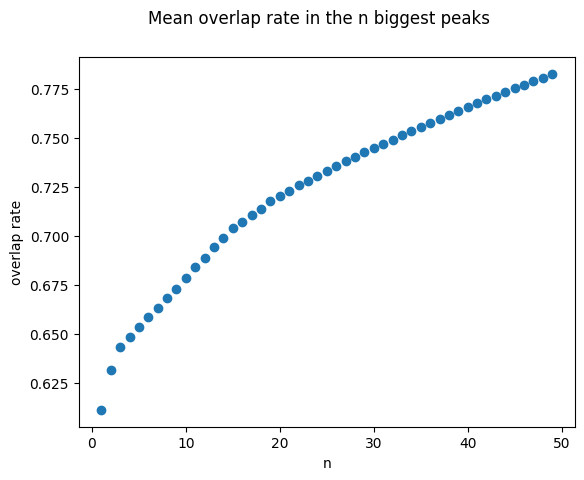

In [32]:
def visualize_mean_overlap(base_data, olap_data, n):
    means = []
    for i in range(1, n):
        overlaps = [compute_overlap(olap_data[k1],base_data[k2], i) for k1, k2 in list(zip(neims_test_spec.keys(),  nist_test_spec.keys()))]
        mean_rate = sum([x/y for x, y in overlaps])/len(overlaps)
        means.append(mean_rate)
        ##########
        #print(str(i) + ":", mean_rate)
    plt.scatter(range(1,n), means)
    plt.xlabel("n")
    plt.ylabel("overlap rate")
    plt.suptitle("Mean overlap rate in the n biggest peaks")
visualize_mean_overlap(nist_test_spec, neims_test_spec, 50)

# Explore categories of molecules

Add to the dictionary the information about categories adapted from:  https://gitlab.unige.ch/Pierre-Marie.Allard/pybatchclassyfire/-/tree/master/notebook

In [ ]:
neims_test.sort_values(by="nist_idMINUS1")


In [ ]:
# convert neims/nist to dataframe
def convert_to_dataframe(dic):
    df = pd.DataFrame.from_dict(dic)#.transpose()
    return df

neims_df = convert_to_dataframe(neims_test).sort_values(by="nist_idMINUS1")
nist_df = convert_to_dataframe(nist_test_spec)

In [ ]:
# get file with inchikeys sorted by nistID
os.makedirs("tmp", exist_ok=True)
with open("./tmp/neims_test_inchikeys.inch", "w") as f:
    for key in sorted(nist_test_spec.keys()):
        f.write(nist_test_spec[key]["inchikey"] + "\n")


Now you copy the inchikeys to the mentioned website's text window and wait for the classed csv

In [ ]:
# read classed csv
enriched_path = "tmp/classed_inchikey8500.csv"
test_classed = pd.read_csv(enriched_path, index_col=0, delimiter="\t")

test_classed

In [ ]:
# add empty classes to nist_test_spec
for col in test_classed.columns:
    nist_df[col] = np.nan

In [ ]:
%%time
# fill given info to the table
def enrich_with_classes(ds_orig):
    counter = 0
    ds = ds_orig.copy()
    for index, row in ds.iterrows():
#         print(row)
        inchi_ds = row["inchikey"]
        if inchi_ds not in test_classed.index:
            continue
            
        for name, val in test_classed.loc[inchi_ds].items():            
            ds.loc[index, name] = val
    print(counter)
    return ds

nist_df_classed = enrich_with_classes(nist_df)

In [ ]:
nist_df_classed

In [ ]:
from matchms import Spectrum
from matchms.similarity import CosineGreedy

# udelej vsechny podobnosti, dej je do Series a tu pak pridej je do NIST_DF
def assign_similarities():
    simils = []
    weighted_simils = []
    matchs = []

    for i in nist_df_classed.index:    
        reference = Spectrum(mz=nist_df_classed.loc[i,"mz"].astype(float),
                             intensities=nist_df_classed.loc[i,"intensity"])
        query = Spectrum(mz=neims_df.loc[i,"mz"].astype(float),
                         intensities=neims_df.loc[i,"intensity"])

        # Use factory to construct a similarity function
        cosine_simil = CosineGreedy(tolerance=0.2, mz_power=0)
        score = cosine_simil.pair(reference, query)
        weighted_cosine_simil = CosineGreedy(tolerance=0.2, mz_power=1)
        w_score = weighted_cosine_simil.pair(reference, query)


#         print(round(score['score'].item)
        simils.append(np.around(score['score'], 2))
        weighted_simils.append(np.around(w_score['score'], 2))
        matchs.append(score['matches'])

    assert len(simils) == len(nist_df_classed) and len(matchs) == len(nist_df_classed)
    nist_df_classed["simil_to_neims"] = simils
    nist_df_classed["weighted_simil_to_neims"] = weighted_simils
    nist_df_classed["matched_peaks_neims"] = matchs
    
assign_similarities()    


In [ ]:
# add rate of matched peaks
rate = [round(nist_df_classed.loc[i,"matched_peaks_neims"]/len(nist_df_classed.loc[i,"mz"]), 2) for i in nist_df_classed.index]
nist_df_classed["matched_rate"] = rate

In [ ]:
nist_df_classed.loc[nist_df_classed["Class"].notna()]

### Class Stats

In [ ]:
# stat: pocty hodnot jednotlivych sloupcu
for inspected_col in ["Kingdom", "Superclass", "Class", "Subclass"]:
    print(f"\t{inspected_col}:")
    print(nist_df_classed[inspected_col].value_counts())

# => smysl dava asi operovat na Superclass

In [ ]:
inspected_col = "Superclass"
# nist classed-only
nist_co = nist_df_classed.loc[nist_df_classed[inspected_col].notna()].copy()

In [ ]:
# stat: prumerna podobnost u Superclass i se zminkou o poctu vzorku
stats = []
for cat in sorted(nist_co["Superclass"].unique()):
    cat_slice = nist_co.loc[nist_co["Superclass"] == cat]
    avg_simils = sum(cat_slice["simil_to_neims"])/len(cat_slice)
    avg_w_simils = sum(cat_slice["weighted_simil_to_neims"])/len(cat_slice)
    avg_matched_peaks = sum(cat_slice["matched_peaks_neims"])/len(cat_slice)
    avg_matched_rate = sum(cat_slice["matched_rate"])/len(cat_slice)
    avg_spec_len = sum([len(nist_df_classed.loc[i,"mz"]) for i in cat_slice.index])/len(cat_slice)
    stats.append([len(cat_slice), round(avg_simils, 2), round(avg_w_simils, 2), round(avg_spec_len,2), round(avg_matched_peaks,2), round(avg_matched_rate,2)])
    #print(f'{cat}: {avg_simils}')

In [ ]:
stats_df = pd.DataFrame(stats, index=sorted(nist_co["Superclass"].unique()), columns=["count", "avg_simil", "avg_w_simil", "avg_spec_len", "avg_matched_peaks", "avg_matched_rate"])
stats_df

In [ ]:
# Create some mock data
cat1 = "avg_w_simil" # "count"
cat2 = "avg_simil"

def visualize_two_cats(cat1, cat2):
    fig = plt.figure() # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

    width = 0.2
    stats_df[cat1].plot(kind='bar', color='blue', ax=ax, position=1, figsize=(15,6), width=width)
    stats_df[cat2].plot(kind='bar', color='salmon', ax=ax2, position=0, figsize=(15,6), width=width, legend=cat2)

    ax.set_ylabel(cat1)
    ax2.set_ylabel(cat2)
#     plt.legend(cat1,cat2)
    plt.show()
    
visualize_two_cats(cat1, cat2)

===================================================================================================================================================================

# HW Vizualizace

In [36]:
nist_df_one_arr

NameError: name 'nist_df_one_arr' is not defined

In [38]:
# chceme: obe spektra v jednom reprezentovany jako list 
    # + smiles, inchikey, simil, w. simil, superclass (naslende dropni co nemaji), molecule (z neims_test), name(z nist_test_spec)
# create nist and neims spectra that do not have mz, only 0 on positions that have zero
def put_spectra_to_one_array(data):
    spectra = []
    for index, row in data.iterrows():
#         print(spec)
        mzs = row["mz"]
        ints = row["intensity"]
        max_ = max(mzs)
        new_spec = np.zeros(max_+1)
        for i in range(len(mzs)):
            new_spec[mzs[i]] = ints[i]
        spectra.append(new_spec)
        if spectra == []:
            print(spectra)
    print(len(spectra))
    data["spectrum"] = spectra
    return data

# toto by se mozna hodilo dat vys rovnou -_o_-

neims_df_one_arr = put_spectra_to_one_array(neims_df)
nist_df_one_arr = put_spectra_to_one_array(nist_df_classed)    


10824
10824


name  \
14                                               Ethylene   
21                                                 Ethane   
29                                            Methylamine   
35                                              Hydrazine   
40                                          Hydroxylamine   
...                                                   ...   
350115  D-Altro-2-Heptulose, 1,3,4,5,6-pentakis-O-(tri...   
350413                                         Tristearin   
350447                           Sucrose, 8TMS derivative   
350463      D-(+)-Cellobiose, (isomer 1), 8TMS derivative   
350529  Butanoic acid, heptafluoro-, 4-[1-(2,2,3,3,4,4...   

                                                   smiles  \
14                                                    C=C   
21                                                     CC   
29                                                     CN   
35                                                     NN   
40                                                     NO   
...                                                   ...   
350115  C[Si](C)(C)OCC(=O)C(C(C(C(COP(=O)(O[Si](C)(C)C...   
350413  CCCCCCCCCCCCCCCCCC(=O)OCC(COC(=O)CCCCCCCCCCCCC...   
350447  C[Si](C)(C)OCC1C(C(C(C(O1)OC2(C(C(C(O2)CO[Si](...   
350463  C[Si](C)(C)OCC1C(C(C(C(O1)O[Si](C)(C)C)O[Si](C...   
350529  CN(CC(C1=CC(=C(C=C1)OC(=O)C(C(C(F)(F)F)(F)F)(F...   

                           inchikey                       superclass  simil  \
14      VGGSQFUCUMXWEO-UHFFFAOYSA-N                     Hydrocarbons   0.94   
21      OTMSDBZUPAUEDD-UHFFFAOYSA-N                     Hydrocarbons   0.73   
29      BAVYZALUXZFZLV-UHFFFAOYSA-N       Organic nitrogen compounds   0.76   
35      OAKJQQAXSVQMHS-UHFFFAOYSA-N  Homogeneous non-metal compounds   0.89   
40      AVXURJPOCDRRFD-UHFFFAOYSA-N  Homogeneous non-metal compounds   0.95   
...                             ...                              ...    ...   
350115  UFLPMPQINYQKLC-UHFFFAOYSA-N                              NaN   0.72   
350413  DCXXMTOCNZCJGO-UHFFFAOYSA-N                              NaN   0.84   
350447  JDAONBLATRVCRV-QZTQCLTNSA-N                              NaN   0.66   
350463  QJZFVYJIGWEKIR-UHFFFAOYSA-N                              NaN   0.74   
350529  ZHEKJTDOISUKEC-UHFFFAOYSA-N                              NaN   0.77   

        w_simil matched_peaks_neims  matched_rate  \
14         0.94                   7          0.58   
21         0.74                   9          0.64   
29         0.79                  12          0.92   
35         0.91                  10          0.91   
40         0.97                  11          0.79   
...         ...                 ...           ...   
350115     0.58                 224          0.76   
350413     0.63                 371          0.95   
350447     0.62                 107          0.99   
350463     0.66                 139          0.90   
350529     0.71                  16          0.73   

                                                nist_spec  \
14      [0.0, 0.0, 0.001001001001001001, 0.0, 0.0, 0.0...   
21      [0.0, 0.0, 0.002002002002002002, 0.0, 0.0, 0.0...   
29      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
35      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
40      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                   ...   
350115  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
350413  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
350447  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
350463  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
350529  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               neims_spec  \
14      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
21      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
29      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
35      [0.0, 0.0, 0.0, 
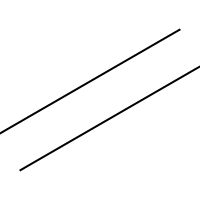
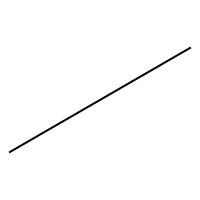
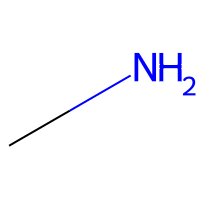
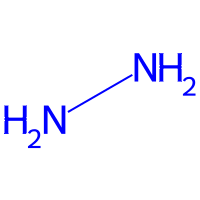
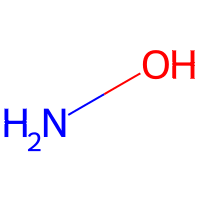
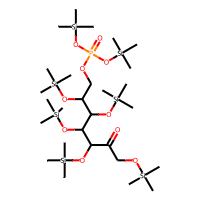
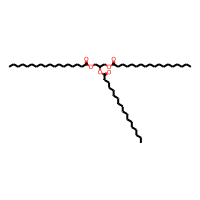
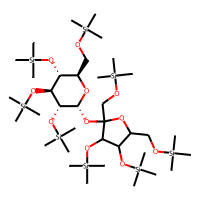
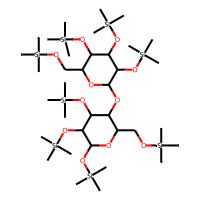
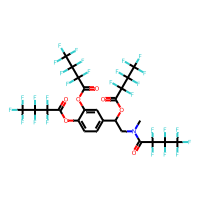

In [59]:
vizu_df

In [84]:
vizu_df = nist_df_one_arr[["name", "smiles", "inchikey", "Superclass", "simil_to_neims", "weighted_simil_to_neims", "matched_peaks_neims", "matched_rate", "spectrum"]]
vizu_df.rename(columns={"spectrum": "nist_spec", "Superclass": "superclass", "simil_to_neims": "simil", "weighted_simil_to_neims": "w_simil", "matched_peaks_neims": "matched_peaks_neims"}, inplace=True)
vizu_df = vizu_df.assign(neims_spec = neims_df_one_arr["spectrum"].tolist())
vizu_df = vizu_df.assign(molecule = neims_test.sort_values(by="nist_idMINUS1")["Molecule"].tolist())
vizu_df = vizu_df[vizu_df.nist_spec.apply(lambda x: len(x)<300)] # filtering according to len

# vizu_df["molecule"] = list(neims_test["Molecule"])

/storage/brno6/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


name  \
14                                               Ethylene   
21                                                 Ethane   
29                                            Methylamine   
35                                              Hydrazine   
40                                          Hydroxylamine   
...                                                   ...   
293615                                          Zopiclone   
300138  1,2-Propanediol, 3-(1-piperidinyl)-, bis(pheny...   
308256                       Heptafluorobutyric anhydride   
319297                         Tetrahexylammonium bromide   
340373                                           Probucol   

                                                   smiles  \
14                                                    C=C   
21                                                     CC   
29                                                     CN   
35                                                     NN   
40                                                     NO   
...                                                   ...   
293615  CN1CCN(CC1)C(=O)OC2C3=NC=CN=C3C(=O)N2C4=NC=C(C...   
300138  C1CCN(CC1)CC(COC(=O)NC2=CC=CC=C2)OC(=O)NC3=CC=...   
308256  C(=O)(C(C(C(F)(F)F)(F)F)(F)F)OC(=O)C(C(C(F)(F)...   
319297             CCCCCC[N+](CCCCCC)(CCCCCC)CCCCCC.[Br-]   
340373  CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)SC(C)(C)SC2=CC...   

                           inchikey                       superclass  simil  \
14      VGGSQFUCUMXWEO-UHFFFAOYSA-N                     Hydrocarbons   0.94   
21      OTMSDBZUPAUEDD-UHFFFAOYSA-N                     Hydrocarbons   0.73   
29      BAVYZALUXZFZLV-UHFFFAOYSA-N       Organic nitrogen compounds   0.76   
35      OAKJQQAXSVQMHS-UHFFFAOYSA-N  Homogeneous non-metal compounds   0.89   
40      AVXURJPOCDRRFD-UHFFFAOYSA-N  Homogeneous non-metal compounds   0.95   
...                             ...                              ...    ...   
293615  GBBSUAFBMRNDJC-UHFFFAOYSA-N                              NaN   0.24   
300138  YUGZHQHSNYIFLG-UHFFFAOYSA-N                              NaN   0.20   
308256  UFFSXJKVKBQEHC-UHFFFAOYSA-N                              NaN   0.87   
319297  SYZCZDCAEVUSPM-UHFFFAOYSA-M                              NaN   0.17   
340373  FYPMFJGVHOHGLL-UHFFFAOYSA-N                              NaN   0.51   

        w_simil matched_peaks_neims  matched_rate  \
14         0.94                   7          0.58   
21         0.74                   9          0.64   
29         0.79                  12          0.92   
35         0.91                  10          0.91   
40         0.97                  11          0.79   
...         ...                 ...           ...   
293615     0.13                 116          0.76   
300138     0.21                  74          0.91   
308256     0.83                  26          0.59   
319297     0.03                  39          0.45   
340373     0.25                 199          0.96   

                                                nist_spec  \
14      [0.0, 0.0, 0.001001001001001001, 0.0, 0.0, 0.0...   
21      [0.0, 0.0, 0.002002002002002002, 0.0, 0.0, 0.0...   
29      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
35      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
40      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                   ...   
293615  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
300138  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
308256  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
319297  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
340373  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               neims_spec  \
14      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
21      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
29      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
35      [0.0, 0.0, 0.0, 
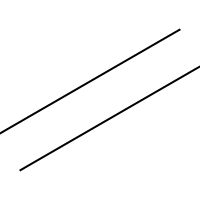
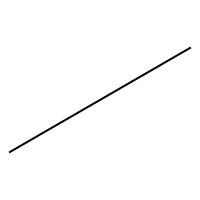
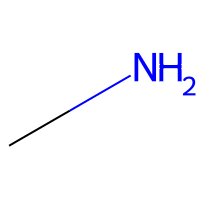
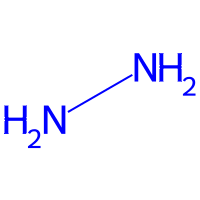
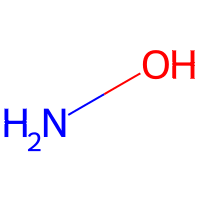
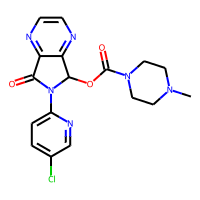
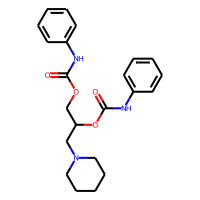
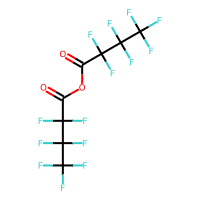
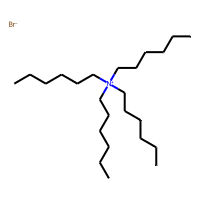
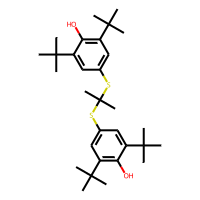

In [85]:
vizu_df

In [58]:
!ls

'ZINC-downloader-2D-smi (1).uri'   nist_test_smiles.sdf     train_bart.ipynb
 data				   nist_test_smiles.txt     vizu_data.csv
 michal_repo			   play_with_smiles.ipynb
 neims_gen_analysis.ipynb	   tmp


In [86]:
vizu_df.to_csv("vizu_data.csv")

In [ ]:
a=4